![Logo de Naturgy](https://cdn.hellowatt.es/media/logos/Naturgy_logo.png)


# Análisis Exploratorio de Datos (EDA) y Modelado Predictivo para Naturgy: Impulsando el Futuro Energético

**Índice del Notebook**

- [1 Exploración Inicial y Limpieza de Datos](#1-exploración-inicial-y-limpieza-de-datos)

  - [Librerías](#librerías)

  - [Paleta de colores](#paleta-de-colores)

  - [Carga y Análisis Individual de Datasets](#carga-y-análisis-individual-de-datasets)

    - [Dataset de Energía Mix Energético Español](#dataset-de-energía-mix-energético-español)

    - [Dataset de Clima](#dataset-de-clima)

- [3. Unión y Creación del Dataset Base](#3-unión-y-creación-del-dataset-base)

  - [**PROBLEMA CON LA UNIDAD DEL VIENTO**](#problema-con-la-unidad-del-viento)

- [4. Análisis Exploratorio del Dataset Combinado](#4-análisis-exploratorio-del-dataset-combinado)

  - [Distribución de Variables Numéricas (Univariante)](#distribución-de-variables-numéricas-univariante)

  - [Análisis de las Variables Objetivo (Targets)](#análisis-de-las-variables-objetivo-targets)

  - [Análisis de Outliers](#análisis-de-outliers)

  - [Análisis de Correlaciones](#análisis-de-correlaciones)

    - [Correlación entre Targets](#correlación-entre-targets)

  - [Series Temporales y Estacionalidad](#series-temporales-y-estacionalidad)

- [5 Limpieza, Procesamiento y Feature Engineering](#5-limpieza-procesamiento-y-feature-engineering)

  - [Tratamiento de outlayers (Extremos)](#tratamiento-de-outlayers-extremos)

  - [Tranformaciones](#tranformaciones)

  - [Análisis del Factor de Inflación de la Varianza (VIF)](#análisis-del-factor-de-inflación-de-la-varianza-vif)

- [6 Featuring Engineering avanzado](#6-featuring-engineering-avanzado)

  - [Ordenación de los dato en orden cronológico](#ordenación-de-los-dato-en-orden-cronológico)

  - [Lags](#lags)

- [7 Pipeline de Procesamiento de datos](#7-pipeline-de-procesamiento-de-datos)

- [8 Preparación y Entrenamiento de modelos](#8-preparación-y-entrenamiento-de-modelos)

  - [Crear las variables objetivo futuras](#crear-las-variables-objetivo-futuras)

  - [Division de datos entrenamiento validacion y prueba final](#division-de-datos-entrenamiento-validacion-y-prueba-final)

  - [Preprocesamiento y Escalado](#preprocesamiento-y-escalado)

  - [XGBoost](#xgboost)

    - [Entrenamiento y Guardado de XGBoost](#entrenamiento-y-guardado-de-xgboost)

  - [Red Neuronal](#red-neuronal)

    - [Preparación de Datos para Red Neuronal](#preparación-de-datos-para-red-neuronal)

    - [Entrenamiento y Guardado de Red Neuronal](#entrenamiento-y-guardado-de-red-neuronal)

  - [Resultados (en Conjunto de Validación)](#resultados-en-conjunto-de-validación)

  - [Conclusiones de los modelos](#conclusiones-de-los-modelos)

- [8 Prueba Final](#8-prueba-final)

  - [Carga de Modelos y Preprocesadores](#carga-de-modelos-y-preprocesadores)

  - [Predicciones y Evaluación en el Conjunto de Prueba Final](#predicciones-y-evaluación-en-el-conjunto-de-prueba-final)

  - [Conclusiones Finales del Rendimiento del Modelo](#conclusiones-finales-del-rendimiento-del-modelo)


Este notebook detalla el desarrollo y la validación de modelos predictivos avanzados diseñados para proporcionar a Naturgy información crítica sobre tres pilares fundamentales del sistema energético: la demanda total de energía (`total load actual`), el precio del mercado eléctrico (`price actual`) y la generación de energía renovable (`total renewable generation`).

Hemos logrado construir modelos capaces de generar pronósticos fiables para estas variables con horizontes de 1 a 6 horas de antelación. Esta capacidad predictiva se traduce directamente en ventajas competitivas y operativas significativas para Naturgy:

*   **Optimización de la Demanda y Generación:** Al predecir la `total load actual` con varias horas de antelación, Naturgy puede optimizar el despacho de sus activos de generación, gestionar eficientemente las reservas energéticas y mejorar la estabilidad de la red, resultando en una operación más económica y segura.

*   **Estrategia de Mercado y Gestión de Riesgos:** Con pronósticos precisos del `price actual`, Naturgy puede afinar sus estrategias de participación en el mercado mayorista, optimizar la compra y venta de energía, y gestionar de manera más efectiva los riesgos asociados a la volatilidad de los precios, beneficiando tanto sus operaciones como las ofertas a sus clientes.

*   **Integración Eficiente de Energías Renovables:** La predicción de la `total renewable generation` permite a Naturgy anticipar la producción de sus fuentes renovables y de las del sistema en general. Esto es clave para gestionar la intermitencia, optimizar el uso de sistemas de respaldo y almacenamiento, y facilitar una integración más fluida y rentable de las energías limpias en el mix energético, alineándose con los objetivos de sostenibilidad.


## 1 Exploración Inicial y Limpieza de Datos

### Librerías

In [486]:
import time
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader


warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (18, 8)

### Paleta de colores

<div style="display: flex; flex-wrap: wrap; gap: 15px; align-items: center; justify-content: center; padding: 10px;">
  <div title="#e37404" style="width:100px; height:100px; background-color:#e37404; border-radius: 8px; box-shadow: 3px 3px 8px rgba(0,0,0,0.2); display: flex; align-items: flex-end; justify-content: center; padding-bottom: 5px;">
    <span style="color: white; font-family: monospace; font-size: 0.9em; background-color: rgba(0,0,0,0.4); padding: 2px 4px; border-radius: 3px;">#e37404</span>
  </div>
  <div title="#efaa66" style="width:100px; height:100px; background-color:#efaa66; border-radius: 8px; box-shadow: 3px 3px 8px rgba(0,0,0,0.2); display: flex; align-items: flex-end; justify-content: center; padding-bottom: 5px;">
    <span style="color: black; font-family: monospace; font-size: 0.9em; background-color: rgba(255,255,255,0.5); padding: 2px 4px; border-radius: 3px;">#efaa66</span>
  </div>
  <div title="#f0b983" style="width:100px; height:100px; background-color:#f0b983; border-radius: 8px; box-shadow: 3px 3px 8px rgba(0,0,0,0.2); display: flex; align-items: flex-end; justify-content: center; padding-bottom: 5px;">
    <span style="color: black; font-family: monospace; font-size: 0.9em; background-color: rgba(255,255,255,0.5); padding: 2px 4px; border-radius: 3px;">#f0b983</span>
  </div>
  <div title="#044474" style="width:100px; height:100px; background-color:#044474; border-radius: 8px; box-shadow: 3px 3px 8px rgba(0,0,0,0.2); display: flex; align-items: flex-end; justify-content: center; padding-bottom: 5px;">
    <span style="color: white; font-family: monospace; font-size: 0.9em; background-color: rgba(0,0,0,0.4); padding: 2px 4px; border-radius: 3px;">#044474</span>
  </div>
  <div title="#628baa" style="width:100px; height:100px; background-color:#628baa; border-radius: 8px; box-shadow: 3px 3px 8px rgba(0,0,0,0.2); display: flex; align-items: flex-end; justify-content: center; padding-bottom: 5px;">
    <span style="color: white; font-family: monospace; font-size: 0.9em; background-color: rgba(0,0,0,0.4); padding: 2px 4px; border-radius: 3px;">#628baa</span>
  </div>
  <div title="#9bb3c4" style="width:100px; height:100px; background-color:#9bb3c4; border-radius: 8px; box-shadow: 3px 3px 8px rgba(0,0,0,0.2); display: flex; align-items: flex-end; justify-content: center; padding-bottom: 5px;">
    <span style="color: black; font-family: monospace; font-size: 0.9em; background-color: rgba(255,255,255,0.5); padding: 2px 4px; border-radius: 3px;">#9bb3c4</span>
  </div>
</div>



In [487]:
naturgy_orange_palette = ['#e37404', '#efaa66', '#f0b983']
naturgy_blue_palette = ['#044474', '#628baa', '#9bb3c4']

### Carga y Análisis Individual de Datasets

#### Dataset de Energía Mix Energético Español

In [488]:
df_energy = pd.read_parquet('../data/energy_silver.parquet/')
print(f"Dataset de Energía cargado con dimensiones: {df_energy.shape}")

Dataset de Energía cargado con dimensiones: (35046, 29)


In [489]:
display(df_energy.head())
display(df_energy.info())
display(df_energy.describe())

time  generation biomass  \
0 2015-02-26 13:00:00               472.0   
1 2015-04-30 07:00:00               382.0   
2 2015-06-13 20:00:00               486.0   
3 2015-06-23 19:00:00               496.0   
4 2015-06-30 23:00:00               497.0   

   generation fossil brown coal or lignite  \
0                                      0.0   
1                                    647.0   
2                                    980.0   
3                                    538.0   
4                                    936.0   

   generation fossil coal-derived gas  generation fossil gas  \
0                                 0.0                 3524.0   
1                                 0.0                 4907.0   
2                                 0.0                 4444.0   
3                                 0.0                 4818.0   
4                                 0.0                 5253.0   

   generation fossil hard coal  generation fossil oil  \
0                       2492.0                  361.0   
1                       6307.0                  363.0   
2                       6650.0                  249.0   
3                       7598.0                  369.0   
4                       6619.0                  274.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ... generation waste  generation wind offshore  generation wind onshore  \
0  ...            202.0                       0.0                  10524.0   
1  ...            185.0                       0.0                   4478.0   
2  ...            280.0                       0.0                   3743.0   
3  ...            268.0                       0.0                   5692.0   
4  ...            237.0                       0.0                   1971.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                    3599.0                            Unknown   
1                    2132.0                            Unknown   
2                     396.0                            Unknown   
3                    1082.0                            Unknown   
4                       2.0                            Unknown   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                          10387.0              33607.0            33320.0   
1                           4514.0              30485.0            30581.0   
2                           3981.0              27127.0            26635.0   
3                           5858.0              30816.0            29731.0   
4                           2174.0              22428.0            23341.0   

   price day ahead  price actual  
0            41.10         53.80  
1            59.99         71.36  
2            62.13         72.12  
3            62.21         75.64  
4            49.67         60.52  

[5 rows x 29 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35046 entries, 0 to 35045
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   time                                         35046 non-null  datetime64[ns]
 1   generation biomass                           35046 non-null  float64       
 2   generation fossil brown coal or lignite      35046 non-null  float64       
 3   generation fossil coal-derived gas           35046 non-null  float64       
 4   generation fossil gas                        35046 non-null  float64       
 5   generation fossil hard coal                  35046 non-null  float64       
 6   generation fossil oil                        35046 non-null  float64       
 7   generation fossil oil shale                  35046 non-null  float64       
 8   generation fossil peat                       35046 non-null  float64       


None

time  generation biomass  \
count                          35046        35046.000000   
mean   2016-12-31 17:28:37.822290688          383.513011   
min              2014-12-31 23:00:00            0.000000   
25%              2016-01-01 16:15:00          333.000000   
50%              2016-12-31 18:30:00          367.000000   
75%              2017-12-31 19:45:00          433.000000   
max              2018-12-31 22:00:00          592.000000   
std                              NaN           85.352783   

       generation fossil brown coal or lignite  \
count                             35046.000000   
mean                                448.059208   
min                                   0.000000   
25%                                   0.000000   
50%                                 509.000000   
75%                                 757.000000   
max                                 999.000000   
std                                 354.568590   

       generation fossil coal-derived gas  generation fossil gas  \
count                             35046.0           35046.000000   
mean                                  0.0            5622.737488   
min                                   0.0               0.000000   
25%                                   0.0            4126.000000   
50%                                   0.0            4969.000000   
75%                                   0.0            6429.000000   
max                                   0.0           20034.000000   
std                                   0.0            2201.830478   

       generation fossil hard coal  generation fossil oil  \
count                 35046.000000           35046.000000   
mean                   4256.065742             298.319808   
min                       0.000000               0.000000   
25%                    2527.000000             263.000000   
50%                    4474.000000             300.000000   
75%                    5838.750000             330.000000   
max                    8359.000000             449.000000   
std                    1961.601013              52.519923   

       generation fossil oil shale  generation fossil peat  \
count                      35046.0                 35046.0   
mean                           0.0                     0.0   
min                            0.0                     0.0   
25%                            0.0                     0.0   
50%                            0.0                     0.0   
75%                            0.0                     0.0   
max                            0.0                     0.0   
std                            0.0                     0.0   

       generation geothermal  ...  generation solar  generation waste  \
count                35046.0  ...      35046.000000      35046.000000   
mean                     0.0  ...       1432.665925        269.452377   
min                      0.0  ...          0.000000          0.000000   
25%                      0.0  ...         71.000000        240.000000   
50%                      0.0  ...        616.000000        279.000000   
75%                      0.0  ...       2578.000000        310.000000   
max                      0.0  ...       5792.000000        357.000000   
std                      0.0  ...       1680.119887         50.194840   

       generation wind offshore  generation wind onshore  \
count                   35046.0             35046.000000   
mean                        0.0              5464.479769   
min                         0.0                 0.000000   
25%                         0.0              2933.000000   
50%                         0.0              4849.000000   
75%                         0.0              7398.000000   
max                         0.0             17436.000000   
std                         0.0              3213.691587   

       forecast solar day ahead  forecast wind onshore day ahead  \
count              35046.000000                    

In [490]:
df_energy.isnull().sum()

time                                           0
generation biomass                             0
generation fossil brown coal or lignite        0
generation fossil coal-derived gas             0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation fossil oil shale                    0
generation fossil peat                         0
generation geothermal                          0
generation hydro pumped storage aggregated     0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation marine                              0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind offs

**Observaciones**: Las fuentes renovables son las que más variabilidad tiene.

Por otra parte hay fuentes que no tienen variabilidad lo que posiblemente pueden eliminarse.

Hay dos columnas de tipo object, teniendo en cuenta que es una tabla de mediciones probablemente se puedan eliminar o estén etiquetadas así por algo durante el proceso de ETL en la capa bronze.

No se aprecian valores nulos.

#### Dataset de Clima

In [491]:
df_weather = pd.read_parquet('../data/weather_features_silver.parquet')
print(f"Dataset de Clima cargado con dimensiones: {df_weather.shape}")

Dataset de Clima cargado con dimensiones: (175271, 15)


In [492]:
display(df_weather.head())
display(df_weather.info())
display(df_weather.describe())

time   city_name    temp  temp_min  temp_max  pressure  \
0 2015-01-16 04:00:00    Valencia  12.100    12.100    12.100      1009   
1 2015-01-26 20:00:00    Valencia   3.748     3.748     3.748      1027   
2 2015-02-24 20:00:00     Seville   9.962     9.962     9.962      1039   
3 2015-03-01 00:00:00      Madrid  14.800    14.800    14.800       942   
4 2015-03-01 19:00:00   Barcelona  16.600    16.600    16.600      1015   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        61        21.6       242      0.0      0.0      0.0          76   
1        77         3.6        46      0.0      0.0      0.0          36   
2        62        14.4       349      0.0      0.0      0.0           0   
3        89         7.2       252      0.0      0.0      0.0           8   
4        90         7.2       225      0.0      0.0      0.0           0   

  weather_main weather_description  
0       clouds       broken clouds  
1       clouds    scattered clouds  
2        clear        sky is clear  
3        clear        sky is clear  
4        clear        sky is clear

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175271 entries, 0 to 175270
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   time                 175271 non-null  datetime64[ns]
 1   city_name            175271 non-null  object        
 2   temp                 175271 non-null  float64       
 3   temp_min             175271 non-null  float64       
 4   temp_max             175271 non-null  float64       
 5   pressure             175271 non-null  int32         
 6   humidity             175271 non-null  int32         
 7   wind_speed           175271 non-null  float64       
 8   wind_deg             175271 non-null  int32         
 9   rain_1h              175271 non-null  float64       
 10  rain_3h              175271 non-null  float64       
 11  snow_3h              175271 non-null  float64       
 12  clouds_all           175271 non-null  int32         
 13  weather_main  

None

time           temp       temp_min  \
count                         175271  175271.000000  175271.000000   
mean   2016-12-31 14:55:28.938614784      16.559508      15.279950   
min              2014-12-31 23:00:00     -10.910000     -10.910000   
25%              2016-01-01 12:00:00      10.681000       9.639750   
50%              2016-12-31 15:00:00      16.000000      15.000000   
75%              2017-12-31 19:00:00      22.090000      21.000000   
max              2018-12-31 22:00:00      42.450000      42.000000   
std                              NaN       8.024963       7.948565   

            temp_max       pressure       humidity     wind_speed  \
count  175271.000000  175271.000000  175271.000000  175271.000000   
mean       18.024507    1016.215871      68.050339       8.889137   
min       -10.910000     918.000000       0.000000       0.000000   
25%        11.777594    1013.000000      53.000000       3.600000   
50%        17.000000    1018.000000      72.000000       7.200000   
75%        24.000000    1022.000000      87.000000      14.400000   
max        48.000000    1090.000000     100.000000     230.400000   
std         8.613761      12.499474      21.813633       7.457877   

            wind_deg        rain_1h        rain_3h        snow_3h  \
count  175271.000000  175271.000000  175271.000000  175271.000000   
mean      166.727097       0.068966       0.000386       0.004848   
min         0.000000       0.000000       0.000000       0.000000   
25%        56.000000       0.000000       0.000000       0.000000   
50%       178.000000       0.000000       0.000000       0.000000   
75%       270.000000       0.000000       0.000000       0.000000   
max       360.000000      12.000000       2.315000      21.500000   
std       116.543511       0.380658       0.007349       0.224579   

          clouds_all  
count  175271.000000  
mean       24.343052  
min         0.000000  
25%         0.000000  
50%        16.000000  
75%        40.000000  
max       100.000000  
std        30.338188

In [493]:
df_weather.isnull().sum()

time                   0
city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_main           0
weather_description    0
dtype: int64

**Observaciones**: Podemos observar que hay datos con muy poca variabilidad sobretedo en rain y snow. Tal vez la mejor opción sea dejar solo el que sea más predictor para nuestros targets.

Por otra parte hay que comprobar las columnas temp ya que me da la sensación de que no varían tanto debido a que es por horas, entonces temp max y min pueden no ser relevantes.


## 3. Unión y Creación del Dataset Base

Como el dataset de energy es a nivel nacional, intentaremos hacer la media de de las condiciones del clima, que es por ciudad. Aunque perdamos algo de información, al calcular a nivel nacional no nos afectará tanto.



### **PROBLEMA CON LA UNIDAD DEL VIENTO**
La naturaleza del viento es vectorial por lo que intar sumarlas como si fuesen escalares sería incorrecto y no representaría el Mundo real.

<div align="center">
    <img src="https://silviaalonsoperez.com/wp-content/uploads/2014/06/zonal_y_meridional1.jpg" alt="Dirección y velocidad del viento con componentes meridional y zonal" width="600"/>
</div>


In [494]:
numeric_cols_weather = numeric_cols_weather = df_weather.select_dtypes(include=np.number).columns

# Conversión a componentes vectoriales del viento
df_weather['wind_x'] = df_weather['wind_speed'] * np.cos(np.radians((90 - df_weather['wind_deg']) % 360))
df_weather['wind_y'] = df_weather['wind_speed'] * np.sin(np.radians((90 - df_weather['wind_deg']) % 360))

# Agregar por tiempo (promediando las componentes vectoriales)
agg_dict = {col: 'mean' for col in numeric_cols_weather}
agg_dict['wind_x'] = 'mean'
agg_dict['wind_y'] = 'mean'

wind_x es la componente zonal del viento, que indica la velocidad del viento en dirección este-oeste.
wind_y es la componente meridional del viento, que indica la velocidad del viento en dirección norte-sur.

La velocidad del viento no se eliminará ya que podría indicar patrones que no están del todo relacionados con la dirección del viento, como por ejemplo la intensidad de una tormenta.

In [495]:
df_weather.describe()

time           temp       temp_min  \
count                         175271  175271.000000  175271.000000   
mean   2016-12-31 14:55:28.938614784      16.559508      15.279950   
min              2014-12-31 23:00:00     -10.910000     -10.910000   
25%              2016-01-01 12:00:00      10.681000       9.639750   
50%              2016-12-31 15:00:00      16.000000      15.000000   
75%              2017-12-31 19:00:00      22.090000      21.000000   
max              2018-12-31 22:00:00      42.450000      42.000000   
std                              NaN       8.024963       7.948565   

            temp_max       pressure       humidity     wind_speed  \
count  175271.000000  175271.000000  175271.000000  175271.000000   
mean       18.024507    1016.215871      68.050339       8.889137   
min       -10.910000     918.000000       0.000000       0.000000   
25%        11.777594    1013.000000      53.000000       3.600000   
50%        17.000000    1018.000000      72.000000       7.200000   
75%        24.000000    1022.000000      87.000000      14.400000   
max        48.000000    1090.000000     100.000000     230.400000   
std         8.613761      12.499474      21.813633       7.457877   

            wind_deg        rain_1h        rain_3h        snow_3h  \
count  175271.000000  175271.000000  175271.000000  175271.000000   
mean      166.727097       0.068966       0.000386       0.004848   
min         0.000000       0.000000       0.000000       0.000000   
25%        56.000000       0.000000       0.000000       0.000000   
50%       178.000000       0.000000       0.000000       0.000000   
75%       270.000000       0.000000       0.000000       0.000000   
max       360.000000      12.000000       2.315000      21.500000   
std       116.543511       0.380658       0.007349       0.224579   

          clouds_all         wind_x         wind_y  
count  175271.000000  175271.000000  175271.000000  
mean       24.343052      -1.377273       0.139367  
min         0.000000    -192.508113     -63.125445  
25%         0.000000      -5.515520      -3.573166  
50%        16.000000       0.000000       0.000000  
75%        40.000000       2.757760       3.600000  
max       100.000000      58.204659     160.049289  
std        30.338188       8.675849       7.579610

In [496]:
numeric_cols_weather = df_weather.select_dtypes(include=np.number).columns
agg_dict = {col: 'mean' for col in numeric_cols_weather}
df_weather_agg = df_weather.groupby('time').agg(agg_dict).reset_index()
df_weather_agg.drop(columns=['wind_deg'], inplace=True) # Columna no necesaria tras la conversión a componentes vectoriales
df_merged = pd.merge(df_energy, df_weather_agg, on='time', how='inner')

# Columnas que tienen un único valor constante
cols_to_drop = [col for col in df_merged.columns if df_merged[col].nunique() == 1]
df_merged = df_merged.drop(columns=cols_to_drop, errors='ignore')

# Columnas de energías renovables
renewable_cols = [
    'generation biomass', 'generation hydro run-of-river and poundage',
    'generation hydro water reservoir', 'generation other renewable',
    'generation solar', 'generation waste', 'generation wind onshore'
]
df_merged['total_renewable_generation'] = df_merged[[col for col in renewable_cols if col in df_merged.columns]].sum(axis=1)

df_merged = df_merged.set_index('time')

print(f"Columnas eliminadas: {cols_to_drop}")
print(f"Dataset unido y limpio. Dimensiones: {df_merged.shape}")

Columnas eliminadas: ['generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation marine', 'generation wind offshore', 'forecast wind offshore eday ahead']
Dataset unido y limpio. Dimensiones: (35046, 33)


**observaciones**: Confirmamos lo que sospechábamos de algunas conlumnas con datos continuos.

El dataset tiene predicciones del TSO de algunas variables claves. Las eliminaré.

In [497]:
tso_cols_to_drop = ['price day ahead', 'forecast wind onshore day ahead', 'forecast solar day ahead', 'total load forecast']
df_cleaned = df_merged.drop(columns=tso_cols_to_drop, errors='ignore')

In [498]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35046 entries, 2015-02-26 13:00:00 to 2018-12-14 11:00:00
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35046 non-null  float64
 1   generation fossil brown coal or lignite      35046 non-null  float64
 2   generation fossil gas                        35046 non-null  float64
 3   generation fossil hard coal                  35046 non-null  float64
 4   generation fossil oil                        35046 non-null  float64
 5   generation hydro pumped storage consumption  35046 non-null  float64
 6   generation hydro run-of-river and poundage   35046 non-null  float64
 7   generation hydro water reservoir             35046 non-null  float64
 8   generation nuclear                           35046 non-null  float64
 9   generation other                     

## 4. Análisis Exploratorio del Dataset Combinado

### Distribución de Variables Numéricas (Univariante)

In [499]:
def plot_distributions(df, columns, n_cols=3, figsize=(15, None), bins=30):
    # Calcular filas necesarias
    n_rows = int(np.ceil(len(columns) / n_cols))
    if figsize[1] is None:
        figsize = (figsize[0], n_rows * 4)
    
    # Crear subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = np.array([axes]).flatten() if n_rows * n_cols == 1 else axes.flatten()
    
    for i, col in enumerate(columns[:len(axes)]):
        ax = axes[i]
        
        # Histograma con KDE en azul
        sns.histplot(df[col], bins=bins, kde=True, ax=ax, alpha=0.7, color=naturgy_blue_palette[0])
        
        # Estadísticas básicas
        mean_val = df[col].mean()
        median_val = df[col].median()
        
        # Líneas de media y mediana
        ax.axvline(mean_val, color=naturgy_orange_palette[0], linewidth=2, label=f'Media: {mean_val:.2f}')
        ax.axvline(median_val, color=naturgy_orange_palette[1], linewidth=2, linestyle='--', 
                  label=f'Mediana: {median_val:.2f}')
        
        # Títulos y etiquetas
        ax.set_title(f'{col}')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Ocultar ejes no usados
    for j in range(len(columns), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()


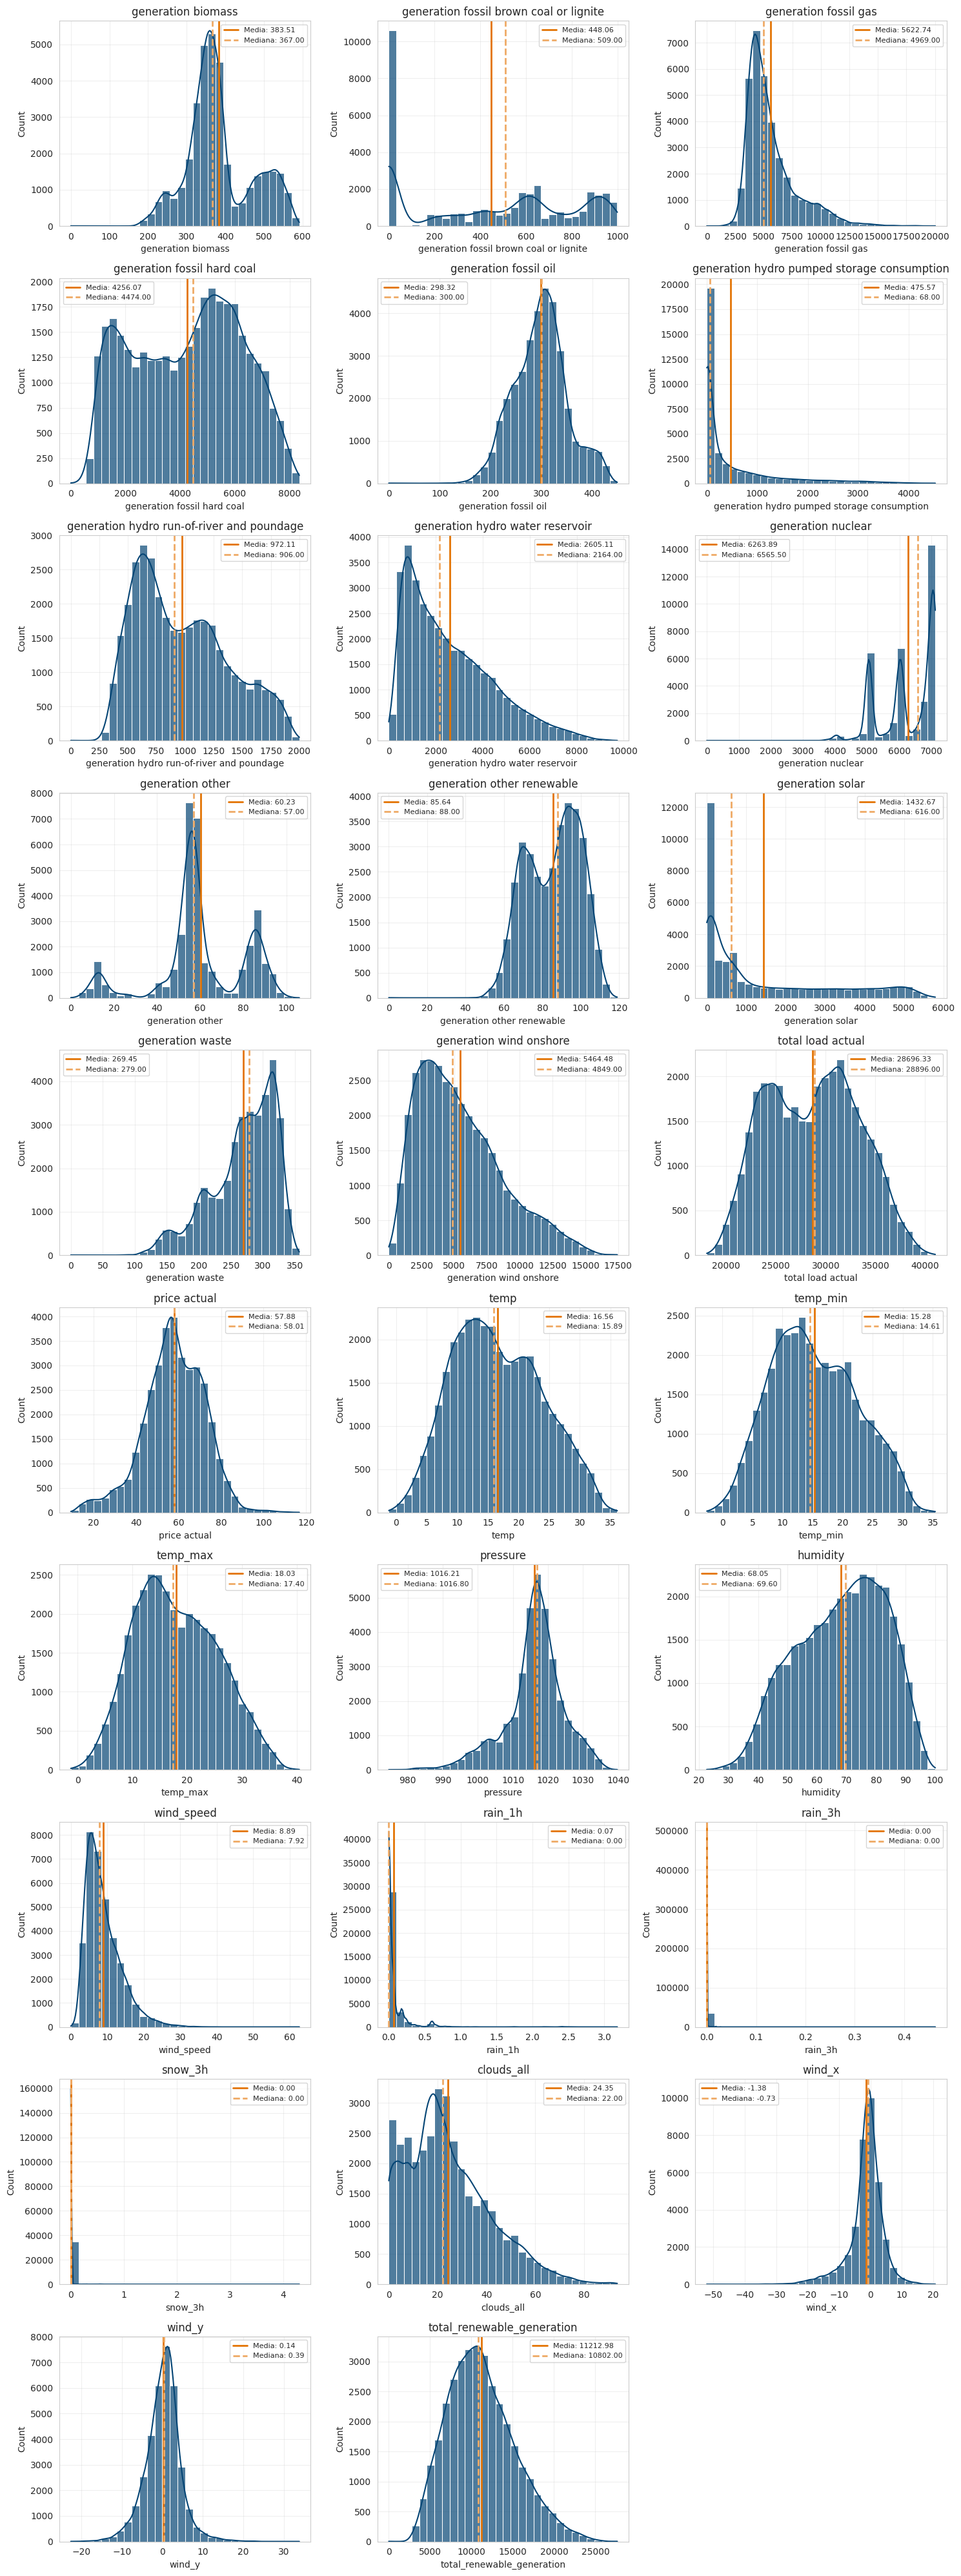

In [500]:
num_cols = df_cleaned.select_dtypes(include=np.number).columns
plot_distributions(df_cleaned, num_cols)

**Observaciones**: hay bastante variedad en las distribuciones:
- Distribuciones con cola a la derecha: una gran parte de las variables muestran este patrón. Podría indicar valores extremos que tendríamos que tratar.
- Distribuciones normales: algunas variables presentan patrones más estables como la temperatura o el precio.
- Distribuciones bimodales/multimodales: podrían indicar patrones en el sistema energético.
- Distribuciones casi en 0: podrían tener muy poca relevancia para predicciones.

### Análisis de las Variables Objetivo (Targets)

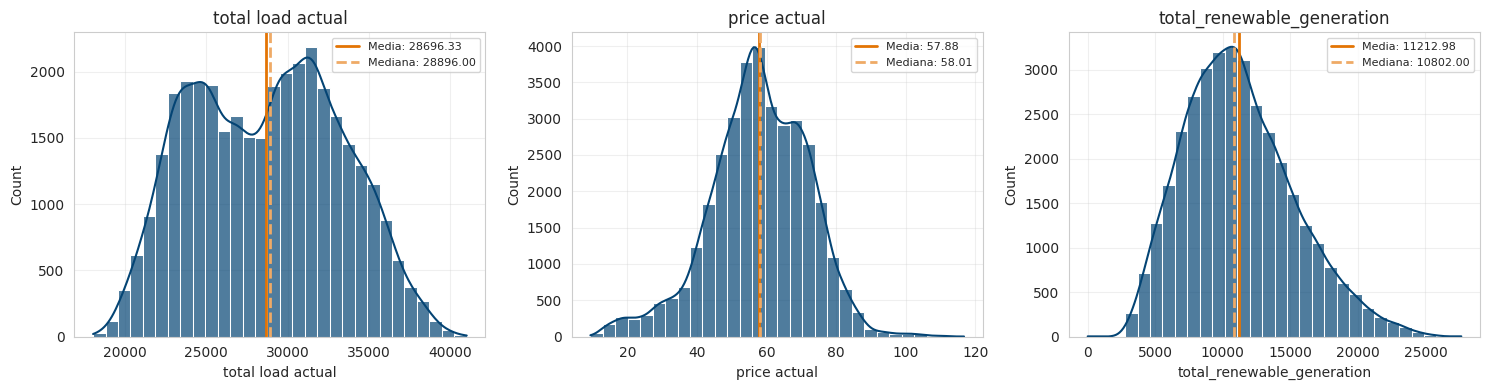

In [501]:
targets_1 = ['total load actual', 'price actual', 'total_renewable_generation']
plot_distributions(df_cleaned, targets_1)


**Observaciones**
- total load actual: se aprecia claramente una distribución bimodal, podría ser por las diferenctes estaciones.
Podría ser interesante hacer una variable categórica que capture los patrones de consumo.
- price actual: tiene una distribución asimétrica positiva con una ligera bimodalidad, podría estar relacionado con la distribución de la generación total. De todas formas tal vez se podría aplicar algún tipo de transformación, eliminar los valores extremos .
- total_renewable_generation: distribución asimétrica pero casi hace una campana de Gauss.



### Análisis de Outliers

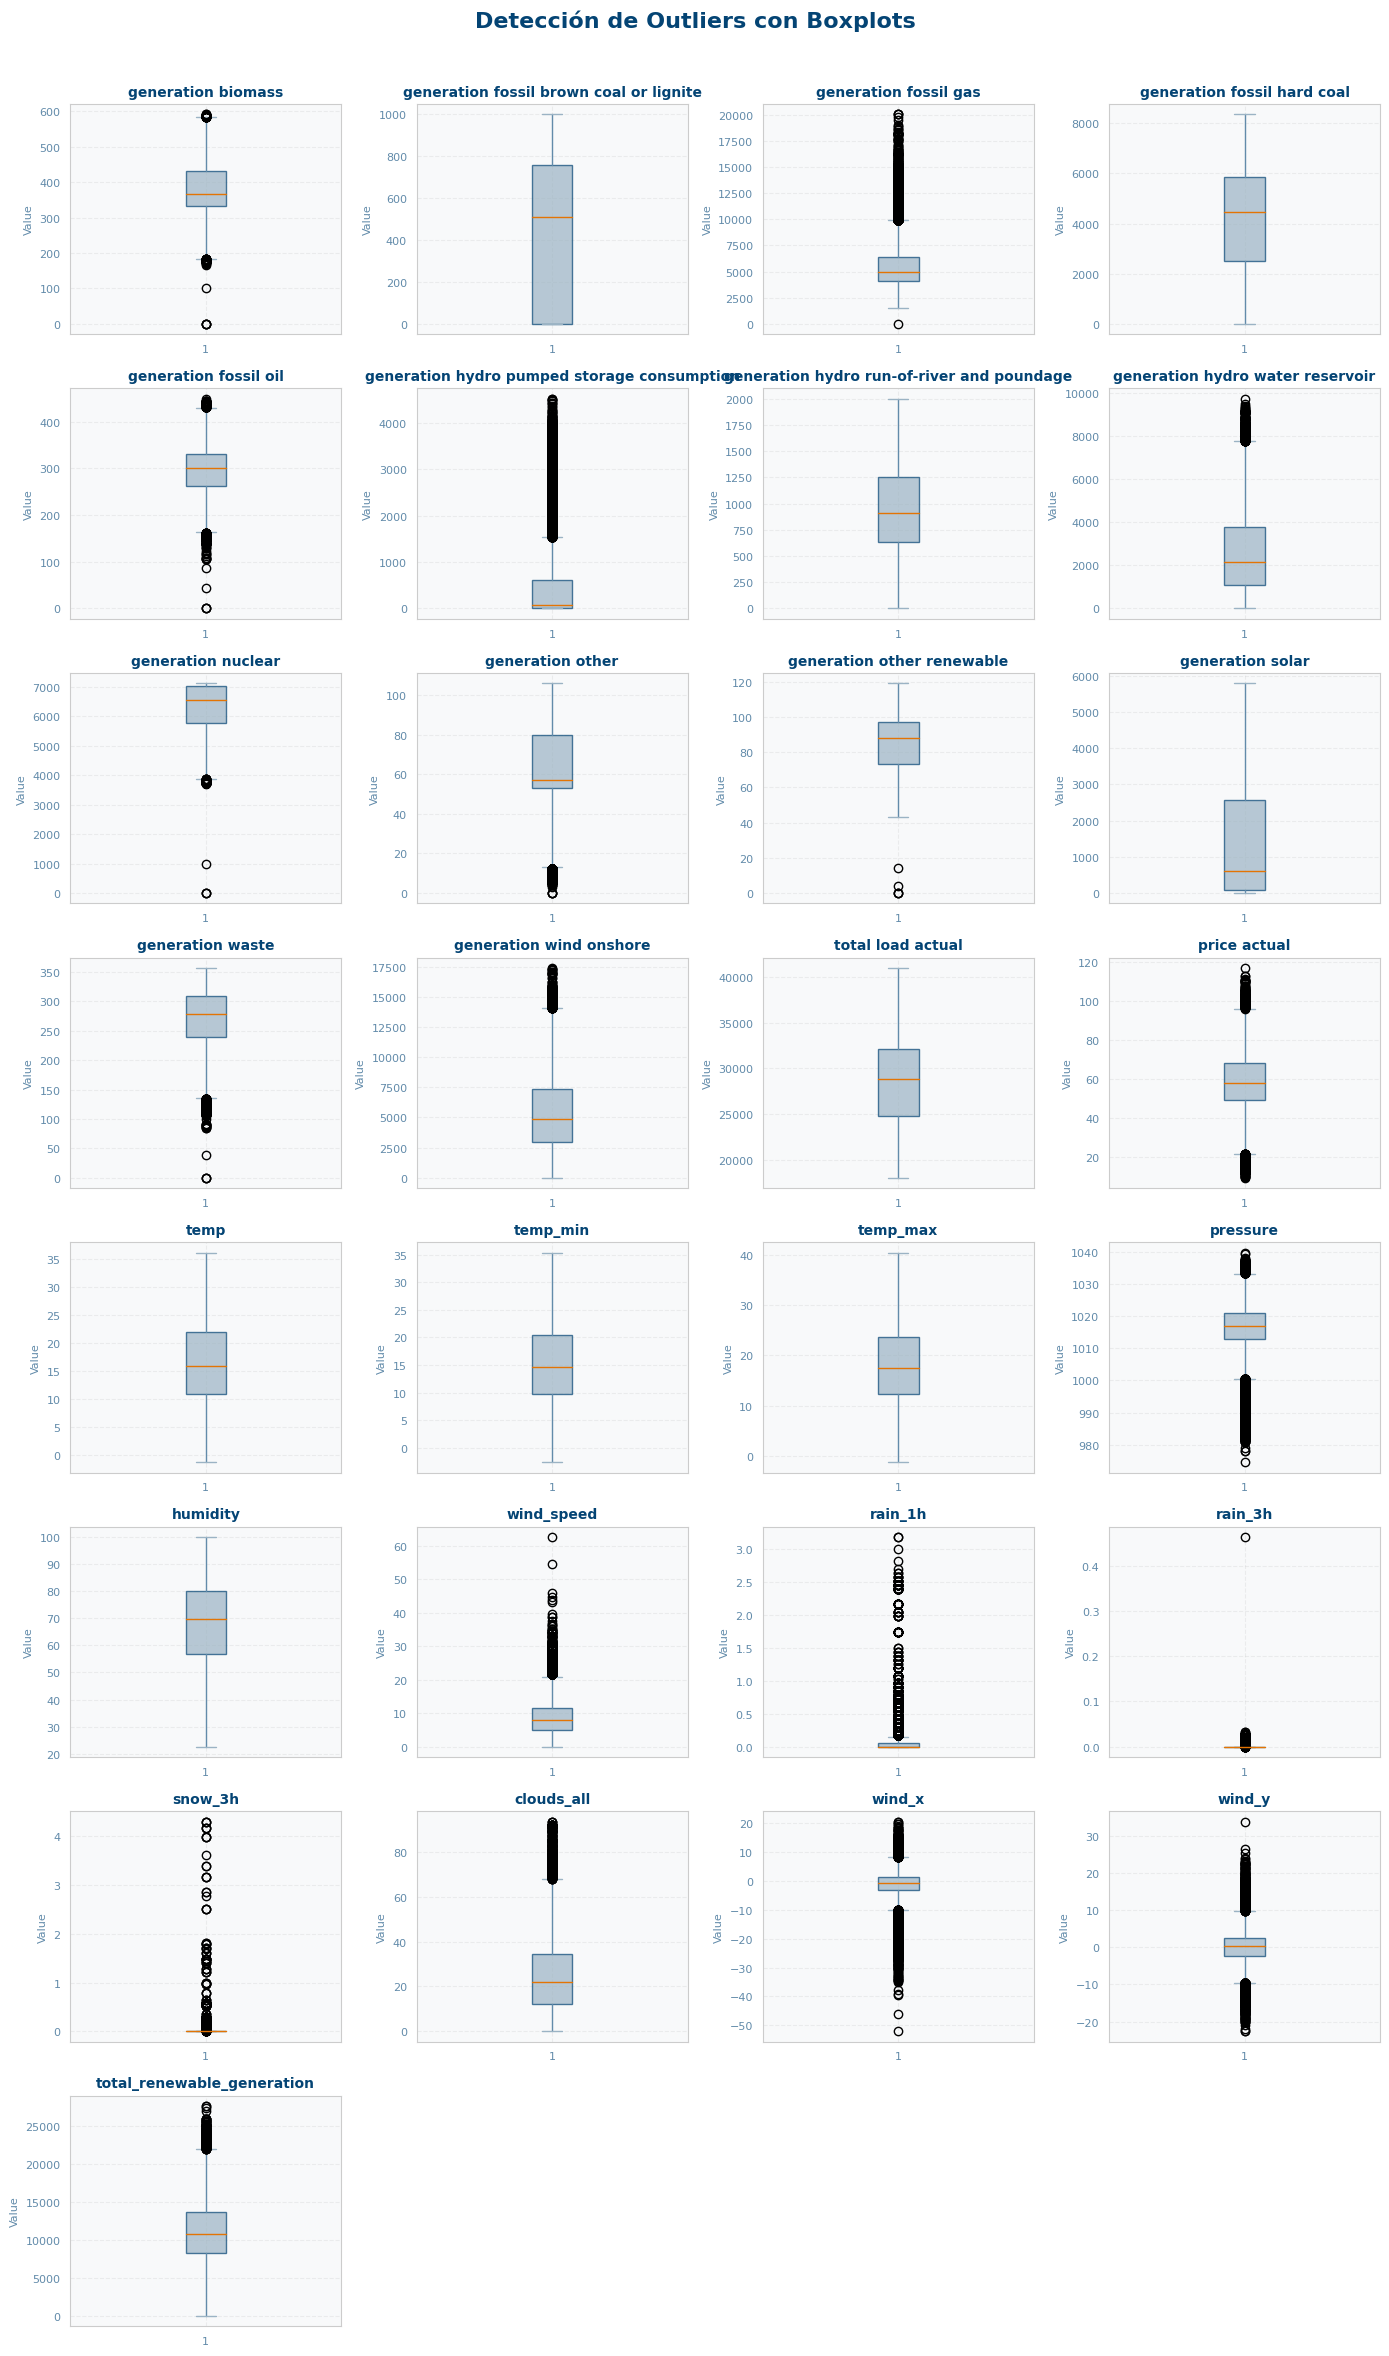

In [502]:
num_cols = df_cleaned.select_dtypes(include=np.number).columns

n_cols = 4
n_rows = int(np.ceil(len(num_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 3))
axes = axes.flatten()

box_colors = {
    'boxes': naturgy_blue_palette[0],
    'whiskers': naturgy_blue_palette[1],
    'medians': naturgy_orange_palette[0],
    'caps': naturgy_blue_palette[2],
    'fliers': naturgy_orange_palette[1]
}

for i, col in enumerate(num_cols):
    if i < len(axes):
        boxplot = axes[i].boxplot(df_cleaned[col], patch_artist=True)
        
        for element, color in box_colors.items():
            plt.setp(boxplot[element], color=color)
            
        for patch in boxplot['boxes']:
            patch.set(facecolor=naturgy_blue_palette[2], alpha=0.7)
            
        axes[i].set_title(col, fontsize=10, color=naturgy_blue_palette[0], fontweight='bold')
        axes[i].tick_params(axis='both', labelsize=8, colors=naturgy_blue_palette[1])
        axes[i].set_xlabel('', fontsize=8)
        axes[i].set_ylabel('Value', fontsize=8, color=naturgy_blue_palette[1])
        
        axes[i].grid(True, linestyle='--', alpha=0.3)
        axes[i].set_facecolor('#f8f9fa')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Detección de Outliers con Boxplots', 
             fontsize=16, 
             color=naturgy_blue_palette[0],
             fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

**Observaciones**: A pesar de que se aprecian numerosos outlayers estos pueden guardan información bastante relevante, como fenómenos atmosféricos extremos. Podría ser interesante tratar solo aqullos que puedan sesgar el modelo.

###  Análisis de Correlaciones

In [503]:
def plot_correlation_matrix(df, figsize=(24, 20), cmap='coolwarm', annot=True, fontsize_annot=8, title = "Matriz de Correlación"):
    
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(
        df, 
        annot=annot, 
        cmap=cmap, 
        center=0, 
        fmt='.2f', 
        annot_kws={"size": fontsize_annot}, 
        cbar_kws={"shrink": 0.8}
    )

    plt.title(title, fontsize=16, color='#044474', fontweight='bold')
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    
    return fig, ax

(<Figure size 2400x2000 with 2 Axes>,
 <Axes: title={'center': 'Matriz de Correlación de Variables Numéricas'}>)

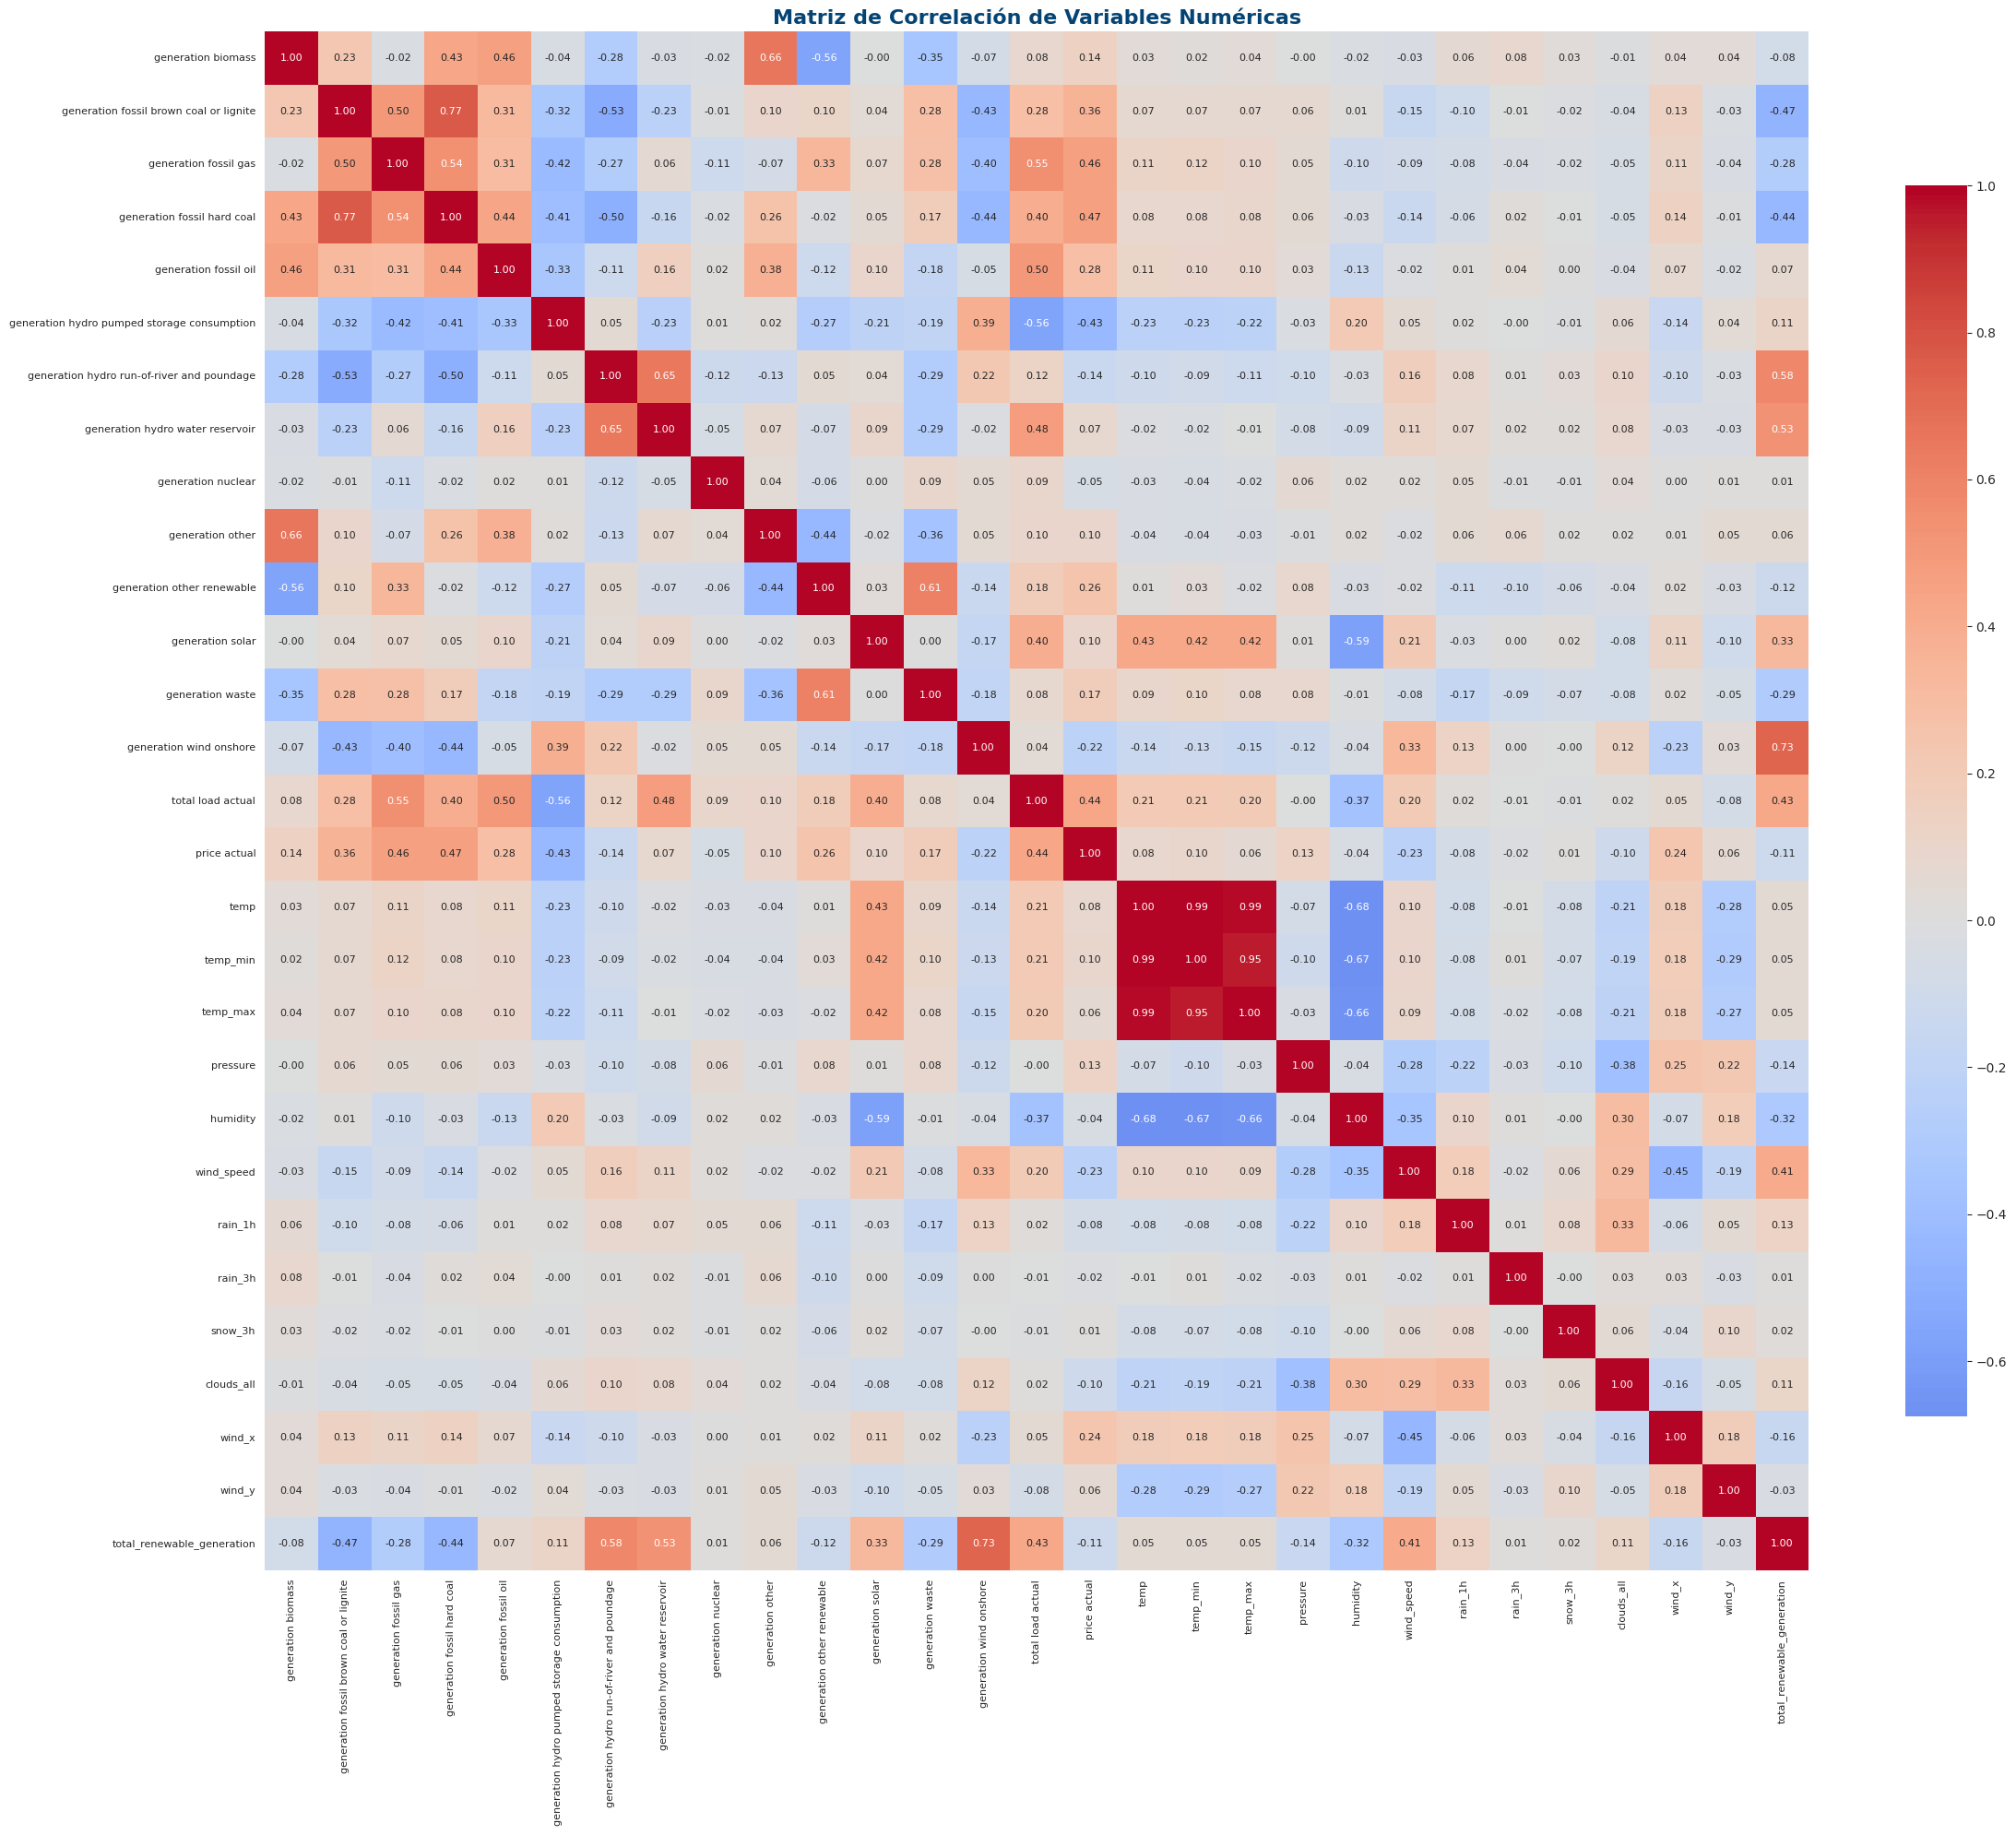

In [504]:
plot_correlation_matrix(df_cleaned.select_dtypes(include=np.number).corr(), title="Matriz de Correlación de Variables Numéricas")


**Observaciones** : Es una tabla con bastantes dimensiones, no obstante probablemente se eliminen variables que no apartan nada y puede añadir ruido.
- Correlación entre fuentes fósiles: nos indica que suben y bajan de forma similar.
- Las condiciones meteorológicos parecen factores determinantes para calcular la genereación de las renovables.
- Las temperaturas entre ellas están demasiado correlacionadas (colinealidad).
- La generación nuclear no parece ser un predictor interesante.


#### Correlación entre Targets
Analizamos específicamente la relación entre nuestras variables objetivo. Esto es clave para un modelo multi-target, ya que una alta correlación puede indicar que los modelos pueden aprender patrones compartidos.

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Matriz de Correlación entre Variables Target'}>)

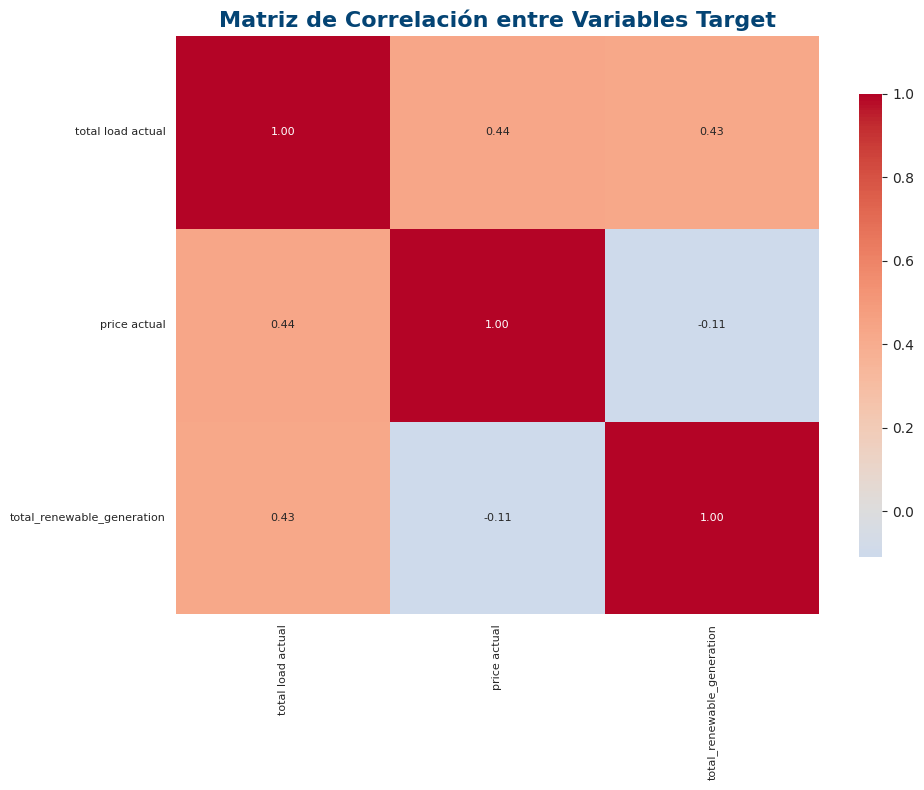

In [505]:

plot_correlation_matrix(df_cleaned[targets_1].corr(), figsize=(10, 8), title="Matriz de Correlación entre Variables Target")

###  Series Temporales y Estacionalidad

Creo que sería interesante añadir columnas basadas en la fecha y hora. Por la naturaleza cíclica de los datos.
De esta forma el modelo podría beneficiarse de patrones que pueda proporcionar las fechas.

## 5 Limpieza, Procesamiento y Feature Engineering

### Tratamiento de outlayers (Extremos)

In [506]:
columns_to_cap = [
    'generation fossil gas', 'generation fossil oil',
    'generation hydro pumped storage consumption',
    'generation biomass', 'pressure', 'wind_speed', 'wind_x', 'wind_y',
]

df_processed = df_cleaned.copy()

for col in columns_to_cap:
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_processed[col] = np.clip(df_processed[col], lower, upper)

### Tranformaciones

Columna 'generation hydro pumped storage consumption' transformada con log1p.
Columna 'rain_1h' transformada con log1p.
Columna 'generation fossil gas' transformada con log.
Columna 'generation hydro water reservoir' transformada con log.


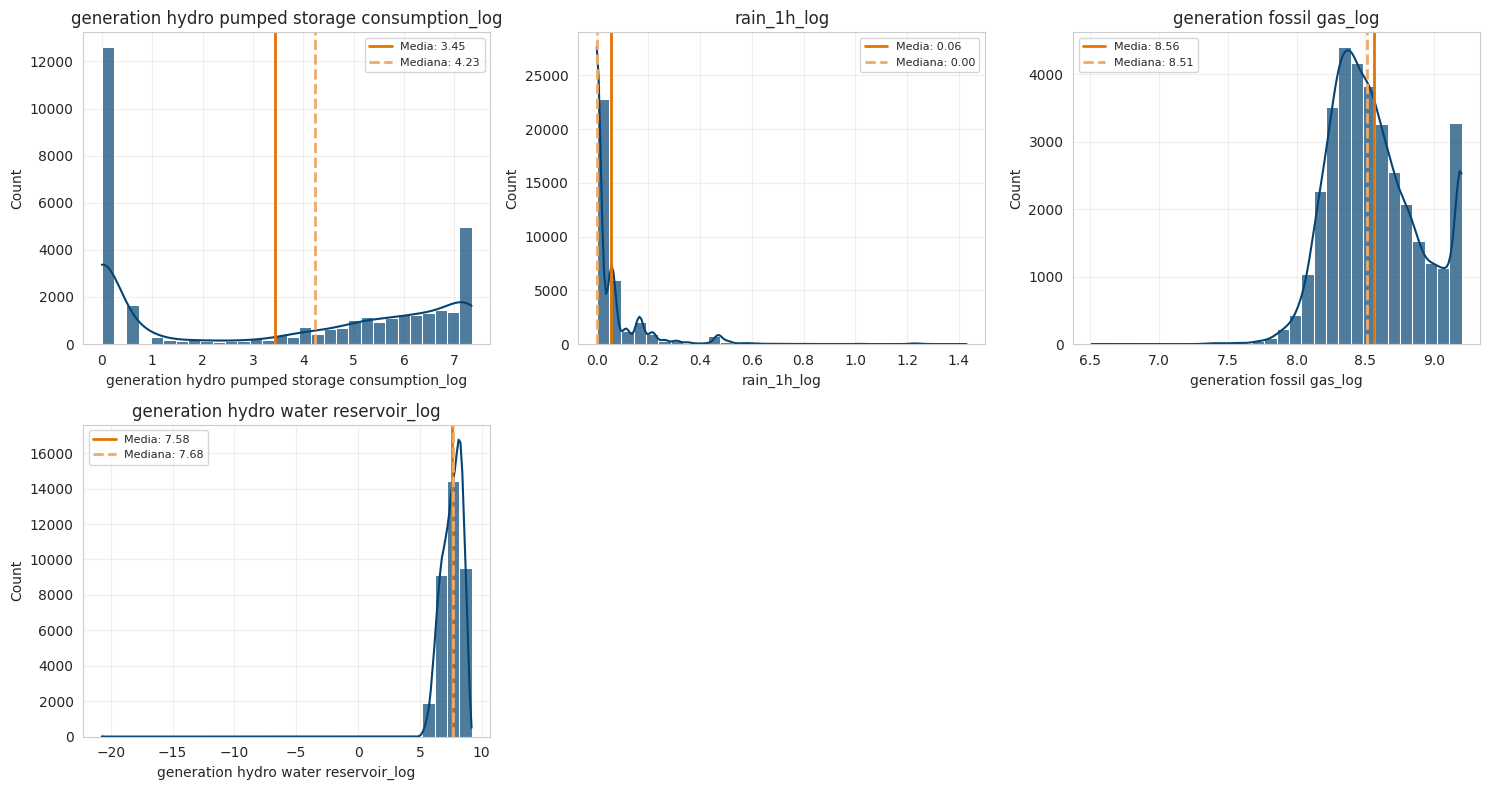

In [507]:
df_transformed = df_processed.copy()

cols_to_log1p = [
    'generation hydro pumped storage consumption',
    'rain_1h',
]

cols_to_log = [
    'generation fossil gas',
    'generation hydro water reservoir',
]

for col in cols_to_log1p:
    if col in df_transformed.columns:
        df_transformed[col] = np.log1p(df_transformed[col])
        df_transformed.rename(columns={col: f'{col}_log'}, inplace=True)
        print(f"Columna '{col}' transformada con log1p.")

epsilon = 1e-9
for col in cols_to_log:
    if col in df_transformed.columns:
        df_transformed[col] = np.log(df_transformed[col] + epsilon)
        df_transformed.rename(columns={col: f'{col}_log'}, inplace=True)
        print(f"Columna '{col}' transformada con log.")


plot_distributions(df_transformed, [f'{c}_log' for c in cols_to_log1p + cols_to_log])

Las gráficas ya muestran una distribución más simétricas en el sentido que media = mediana (aprox)

Con clauds_all provoca un sesgo hacia la izquierda bastante grande y no mejora la distribución, no aplicaré log.

### Análisis del Factor de Inflación de la Varianza (VIF)
El VIF es una medida numérica para la multicolinealidad. Un valor de VIF > 10 es una señal fuerte de que una variable es redundante y podría ser eliminada. Esto ayuda a crear modelos más simples y estables.

In [508]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df_numeric):
    vif_data = pd.DataFrame()
    vif_data['feature'] = df_numeric.columns
    vif_data['VIF'] = [variance_inflation_factor(df_numeric.values, i) for i in range(len(df_numeric.columns))]
    return vif_data.sort_values(by='VIF', ascending=False)

numeric_df = df_transformed.select_dtypes(include=np.number).dropna()
vif_results = calculate_vif(numeric_df)

print("Resultados del VIF (Factor de Inflación de la Varianza):")
display(vif_results.head(20))

Resultados del VIF (Factor de Inflación de la Varianza):


feature          VIF
16                                        temp  7714.952660
19                                    pressure  2887.828290
2                    generation fossil gas_log  2784.263753
18                                    temp_max  2056.436473
17                                    temp_min  1988.810284
7         generation hydro water reservoir_log   413.393396
14                           total load actual   394.255558
28                  total_renewable_generation   307.434760
10                  generation other renewable   111.016859
20                                    humidity    76.294145
8                           generation nuclear    72.803474
13                     generation wind onshore    69.761796
12                            generation waste    66.919433
4                        generation fossil oil    65.248394
0                           generation biomass    64.965086
15                                price actual    31.559148
3                  generation fossil hard coal    28.369906
6   generation hydro run-of-river and poundage    28.091222
9                             generation other    19.192147
11                            generation solar    10.053490

Para producción se podría plantear alguna lógica a la hora de elimnar estas columnas

In [509]:
# Se incluen algunas columnas con vif > 10, las de generación de energías renovables ya que tienen una correlación demasiado alta ya con la total.
cols_to_drop_vif = [
    'generation biomass', 'generation hydro run-of-river and poundage',
    'generation hydro water reservoir', 'generation other renewable',
    'generation solar', 'generation waste', 'generation wind onshore',
    'temp_min', 'temp_max',
]

df_vif_cleaned = df_transformed.drop(columns=cols_to_drop_vif, errors='ignore')
print(f"Dimensiones tras eliminar variables con alto VIF: {df_vif_cleaned.shape}")
df_vif_cleaned.info()

Dimensiones tras eliminar variables con alto VIF: (35046, 21)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35046 entries, 2015-02-26 13:00:00 to 2018-12-14 11:00:00
Data columns (total 21 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   generation fossil brown coal or lignite          35046 non-null  float64
 1   generation fossil gas_log                        35046 non-null  float64
 2   generation fossil hard coal                      35046 non-null  float64
 3   generation fossil oil                            35046 non-null  float64
 4   generation hydro pumped storage consumption_log  35046 non-null  float64
 5   generation hydro water reservoir_log             35046 non-null  float64
 6   generation nuclear                               35046 non-null  float64
 7   generation other                                 35046 non-null  float64
 8   total loa

## 6 Featuring Engineering avanzado

Creamos características temporales y los tranformamos en componentes cíclicas de seno y coseno para capturar la naturaleza cíclica de los datos temporales.

In [510]:
df_vif_cleaned['hour'] = df_vif_cleaned.index.hour
df_vif_cleaned['dayofweek'] = df_vif_cleaned.index.dayofweek
df_vif_cleaned['month'] = df_vif_cleaned.index.month
df_vif_cleaned['year'] = df_vif_cleaned.index.year
df_vif_cleaned['dayofyear'] = df_vif_cleaned.index.dayofyear

# Features cíclicas con sen y cos
# Con esto resolvemos el problema del reloj, el reloj no es una linea recta sino que es un círculo.
df_vif_cleaned['hour_sin'] = np.sin(2 * np.pi * df_vif_cleaned['hour']/24.0)
df_vif_cleaned['hour_cos'] = np.cos(2 * np.pi * df_vif_cleaned['hour']/24.0)

# Para el día de la semana (ciclo de 7 días)
df_vif_cleaned['dayofweek_sin'] = np.sin(2 * np.pi * df_vif_cleaned['dayofweek']/7.0)
df_vif_cleaned['dayofweek_cos'] = np.cos(2 * np.pi * df_vif_cleaned['dayofweek']/7.0)

# Para el mes del año (ciclo de 12 meses)
df_vif_cleaned['month_sin'] = np.sin(2 * np.pi * df_vif_cleaned['month']/12.0)
df_vif_cleaned['month_cos'] = np.cos(2 * np.pi * df_vif_cleaned['month']/12.0)

# Para el día del año (ciclo de 365 días)
df_vif_cleaned['dayofyear_sin'] = np.sin(2 * np.pi * df_vif_cleaned['dayofyear']/365.0)
df_vif_cleaned['dayofyear_cos'] = np.cos(2 * np.pi * df_vif_cleaned['dayofyear']/365.0)

# Eliminar las columnas temporales lineales
cols_to_drop_cyclical = ['hour', 'dayofweek', 'month', 'year', 'dayofyear']
df_vif_cleaned = df_vif_cleaned.drop(columns=cols_to_drop_cyclical, errors='ignore')
print(f"Dimensiones tras añadir variables cíclicas: {df_vif_cleaned.shape}")

Dimensiones tras añadir variables cíclicas: (35046, 29)


Para modelos de predicciones en el futuro, lo ideal es que el conjunto de datos para los modelos aporten preguntas tan simples como: ¿Qué fue lo último que paso hace una?, ¿Cómo era la tendencia hace 24h?, etc. Siguiendo esta lógico podemos aprovecharnos de dos estrategias fundamentales, de esta forma capturaremos información bastante interesante de estas series temporales.

### Ordenación de los dato en orden cronológico

Este paso es el más importante. En mis anteriores intentos mis modelos daban resultados nefastos por debajo de un R2 < 0.001 es decir que no  servía para nada. Esto se debía principalmente a que el corazón de las series temporales es la ordenación cronológica de los datos, si eso no puede aprender estos patrones.

In [511]:
print(df_vif_cleaned.index[:5])

DatetimeIndex(['2015-02-26 13:00:00', '2015-04-30 07:00:00',
               '2015-06-13 20:00:00', '2015-06-23 19:00:00',
               '2015-06-30 23:00:00'],
              dtype='datetime64[ns]', name='time', freq=None)


In [512]:
df_vif_cleaned = df_vif_cleaned.sort_index()
print(df_vif_cleaned.index[:5])

DatetimeIndex(['2014-12-31 23:00:00', '2015-01-01 00:00:00',
               '2015-01-01 01:00:00', '2015-01-01 02:00:00',
               '2015-01-01 03:00:00'],
              dtype='datetime64[ns]', name='time', freq=None)


### Lags
Es el valor de la misma variable en un período anterior (t)
Me recuerda un poco al lag de los videojuegos.

In [513]:
dimensions_before = df_vif_cleaned.shape
def add_lags(df, col, lags, prefix=None):
    if prefix is None:
        prefix = col
    for lag in lags:
        df[f'{prefix}_lag_{lag}h'] = df[col].shift(lag)
    return df

# Lags para nuestros targets
lags_targets = [1, 3, 6, 12, 24, 48, 168, 336]
# Los lags de la generación de renovables ya se generan en las de la generacion de energía
df_vif_cleaned = add_lags(df_vif_cleaned, 'total load actual', lags_targets, prefix='load')
df_vif_cleaned = add_lags(df_vif_cleaned, 'price actual', lags_targets, prefix='price')

# Para las variables de clima
lags_weather = [1, 3, 6, 12, 24, 48, 168, 336]
for col in df_vif_cleaned.columns:
    if 'temp' in col or 'rain' in col or 'wind' in col or 'pressure' in col or 'clouds' in col:
        df_vif_cleaned = add_lags(df_vif_cleaned, col, lags_weather, prefix=col)

# Para la generación de energía
lags_generation = [1, 3, 6, 12, 24, 48, 168, 336]
for col in df_vif_cleaned.columns:
    if 'generation' in col:
        df_vif_cleaned = add_lags(df_vif_cleaned, col, lags_generation, prefix=col)

## 7 Pipeline de Procesamiento de datos

In [ ]:
def preprocess_data_pipeline(energy_parquet_path: str, 
                             weather_parquet_path: str, 
                             is_training: bool = True) -> pd.DataFrame:
    """
    Función completa para preprocesar los datos de energía y clima

    Args:
        energy_parquet_path (str): Ruta al archivo parquet de datos de energía.
        weather_parquet_path (str): Ruta al archivo parquet de datos de clima.
        is_training (bool): True si los datos se procesan para entrenamiento 
                              (se crearán targets futuros). 
                              False para predicción (no se crean targets futuros).

    Returns:
        pd.DataFrame: DataFrame procesado y listo para el siguiente paso 
                      (separación X/y o predicción).
    """
    print("Iniciando pipeline de preprocesamiento de datos...")

    # --- 1. Carga de Datasets ---
    print(f"Cargando datos de energía desde: {energy_parquet_path}")
    df_energy = pd.read_parquet(energy_parquet_path)
    print(f"Cargando datos de clima desde: {weather_parquet_path}")
    df_weather = pd.read_parquet(weather_parquet_path)

    # --- 2. Preprocesamiento de Datos de Clima y Unión ---
    print("Preprocesando datos de clima y uniendo datasets...")
    if 'wind_speed' in df_weather.columns and 'wind_deg' in df_weather.columns:
        df_weather['wind_x'] = df_weather['wind_speed'] * np.cos(np.radians((90 - df_weather['wind_deg']) % 360))
        df_weather['wind_y'] = df_weather['wind_speed'] * np.sin(np.radians((90 - df_weather['wind_deg']) % 360))
    else:
        print("Advertencia: 'wind_speed' o 'wind_deg' no encontradas en datos de clima. Omitiendo wind_x/wind_y.")

    numeric_cols_weather = df_weather.select_dtypes(include=np.number).columns.tolist()
    agg_dict = {col: 'mean' for col in numeric_cols_weather if col in df_weather.columns}
    if 'wind_x' in agg_dict: agg_dict['wind_x'] = 'mean' # Asegurar que se usa si existe
    if 'wind_y' in agg_dict: agg_dict['wind_y'] = 'mean'

    if 'time' not in df_weather.columns:
        raise ValueError("Columna 'time' no encontrada en df_weather, necesaria para la agregación.")
    df_weather_agg = df_weather.groupby('time').agg(agg_dict).reset_index()

    df_merged = pd.merge(df_energy, df_weather_agg, on='time', how='inner')

    cols_to_drop_constant = [col for col in df_merged.columns if df_merged[col].nunique(dropna=False) == 1]
    if cols_to_drop_constant:
        print(f"Eliminando columnas constantes: {cols_to_drop_constant}")
        df_merged = df_merged.drop(columns=cols_to_drop_constant, errors='ignore')

    renewable_cols_list = [
        'generation biomass', 'generation hydro run-of-river and poundage',
        'generation hydro water reservoir', 'generation other renewable',
        'generation solar', 'generation waste', 'generation wind onshore'
    ]
    existing_renewable_cols = [col for col in renewable_cols_list if col in df_merged.columns]
    if existing_renewable_cols:
        df_merged['total_renewable_generation'] = df_merged[existing_renewable_cols].sum(axis=1)
    else:
        print("Advertencia: Columnas de generación renovable no encontradas. 'total_renewable_generation' será 0.")
        df_merged['total_renewable_generation'] = 0
    
    if 'time' not in df_merged.columns:
        raise ValueError("Columna 'time' no encontrada en df_merged, necesaria para el índice.")
    df_merged = df_merged.set_index('time')
    df_merged.index = pd.to_datetime(df_merged.index)

    tso_cols_to_drop_list = ['price day ahead', 'forecast wind onshore day ahead', 'forecast solar day ahead', 'total load forecast']
    existing_tso_cols = [col for col in tso_cols_to_drop_list if col in df_merged.columns]
    if existing_tso_cols:
        print(f"Eliminando columnas TSO: {existing_tso_cols}")
        df_processed = df_merged.drop(columns=existing_tso_cols, errors='ignore')
    else:
        df_processed = df_merged.copy()

    # --- 3. Limpieza, Procesamiento y Feature Engineering Adicional ---
    print("Aplicando tratamiento de outliers y transformaciones...")
    columns_to_cap_list = [
        'generation fossil gas', 'generation fossil oil', 
        'generation biomass', 'pressure', 'wind_speed', 'wind_x', 'wind_y',
    ]
    for col in columns_to_cap_list:
        if col in df_processed.columns:
            Q1 = df_processed[col].quantile(0.25); Q3 = df_processed[col].quantile(0.75)
            IQR = Q3 - Q1
            df_processed[col] = np.clip(df_processed[col], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
        else: print(f"Advertencia: Columna para capping '{col}' no encontrada.")

    cols_to_log1p_list = ['generation fossil oil', 'generation hydro pumped storage consumption']
    cols_to_log_list = ['generation fossil gas', 'generation hydro water reservoir', 'wind_speed']
    epsilon = 1e-9

    for col in cols_to_log1p_list:
        if col in df_processed.columns:
            df_processed[f'{col}_log1p'] = np.log1p(df_processed[col])
            df_processed.drop(columns=[col], inplace=True, errors='ignore')
        else: print(f"Advertencia: Columna para log1p '{col}' no encontrada.")
            
    for col in cols_to_log_list:
        if col in df_processed.columns:
            df_processed[f'{col}_log'] = np.log(df_processed[col] + epsilon)
            df_processed.drop(columns=[col], inplace=True, errors='ignore') 
        else: print(f"Advertencia: Columna para log '{col}' no encontrada.")

    print("Creando características temporales...")
    df_processed['hour_val'] = df_processed.index.hour
    df_processed['dayofweek_val'] = df_processed.index.dayofweek
    df_processed['month_val'] = df_processed.index.month
    df_processed['year_val'] = df_processed.index.year
    df_processed['dayofyear_val'] = df_processed.index.dayofyear

    df_processed['hour_sin'] = np.sin(2 * np.pi * df_processed['hour_val'] / 24.0)
    df_processed['hour_cos'] = np.cos(2 * np.pi * df_processed['hour_val'] / 24.0)
    df_processed['dayofweek_sin'] = np.sin(2 * np.pi * df_processed['dayofweek_val'] / 7.0)
    df_processed['dayofweek_cos'] = np.cos(2 * np.pi * df_processed['dayofweek_val'] / 7.0)
    df_processed['month_sin'] = np.sin(2 * np.pi * df_processed['month_val'] / 12.0)
    df_processed['month_cos'] = np.cos(2 * np.pi * df_processed['month_val'] / 12.0)
    df_processed['dayofyear_sin'] = np.sin(2 * np.pi * df_processed['dayofyear_val'] / 365.0)
    df_processed['dayofyear_cos'] = np.cos(2 * np.pi * df_processed['dayofyear_val'] / 365.0)

    cols_to_drop_vif_list = [ 
        'generation biomass', 'generation hydro run-of-river and poundage',
        'generation hydro water reservoir',
        'generation hydro water reservoir_log',
        'generation other renewable', 'generation solar', 'generation waste', 
        'generation wind onshore', 'temp_min', 'temp_max',
        'year_val', 'month_val', 'dayofyear_val', 'hour_val', 'dayofweek_val'
    ]
    
    actual_cols_to_drop_vif = [col for col in cols_to_drop_vif_list if col in df_processed.columns]
    if actual_cols_to_drop_vif:
        print(f"Eliminando columnas por VIF (predefinidas): {actual_cols_to_drop_vif}")
        df_vif_cleaned = df_processed.drop(columns=actual_cols_to_drop_vif, errors='ignore')
    else:
        df_vif_cleaned = df_processed.copy()

    # --- 4. Feature Engineering Avanzado (Lags) ---
    print("Aplicando feature engineering avanzado (lags)...")
    df_vif_cleaned = df_vif_cleaned.sort_index()

    lag_periods = [1, 3, 6, 12, 24, 48, 168, 336]
    
    cols_for_target_lags = {
        'load': 'total load actual', 
        'price': 'price actual',
        'renewable_gen': 'total_renewable_generation'
    }
    for prefix, source_col in cols_for_target_lags.items():
        if source_col in df_vif_cleaned.columns:
            for lag in lag_periods:
                df_vif_cleaned[f'{prefix}_lag_{lag}h'] = df_vif_cleaned[source_col].shift(lag)
        else: print(f"Advertencia: Columna fuente para lags de target '{source_col}' no encontrada.")

    cols_to_exclude_from_other_lags = list(cols_for_target_lags.values()) + \
                                      [col for col in df_vif_cleaned.columns if '_lag_' in col or '_sin' in col or '_cos' in col]
    
    other_cols_for_lags = [col for col in df_vif_cleaned.columns if col not in cols_to_exclude_from_other_lags and df_vif_cleaned[col].dtype in [np.float64, np.int64]]

    for col_name in other_cols_for_lags:
        safe_prefix = col_name.replace(' ', '_').replace('-', '_').lower()
        for lag in lag_periods:
            df_vif_cleaned[f'{safe_prefix}_lag_{lag}h'] = df_vif_cleaned[col_name].shift(lag)
            
    rolling_lag_windows_list = [1, 3, 6, 12, 24, 48]
    rolling_base_cols_map = {
        'load_mean': 'total load actual',
        'price_mean': 'price actual',
        'renewable_mean': 'total_renewable_generation'
    }
    for prefix_key, original_col in rolling_base_cols_map.items():
        if original_col in df_vif_cleaned.columns:
            for lag_window in rolling_lag_windows_list:
                df_vif_cleaned[f'{prefix_key}_{lag_window}h_lag_{lag_window}h'] = df_vif_cleaned[original_col].shift(lag_window)
        else: print(f"Advertencia: Columna base para 'rolling lags' '{original_col}' no encontrada.")
    
    print("Eliminando NaNs introducidos por lags...")
    df_vif_cleaned = df_vif_cleaned.dropna()

    # --- 5. Creación de Variables Objetivo Futuras ---
    final_df = df_vif_cleaned.copy()
    if is_training:
        print("Creando variables objetivo futuras...")
        targets_to_create_map = {
            'renewable_H_plus_6': ('total_renewable_generation', -6),
            'load_H_plus_6': ('total load actual', -6),
            'price_H_plus_6': ('price actual', -6),
            'renewable_H_plus_1': ('total_renewable_generation', -1),
            'load_H_plus_1': ('total load actual', -1),
            'price_H_plus_1': ('price actual', -1)
        }
        for new_target_col, (source_col, shift_val) in targets_to_create_map.items():
            if source_col in final_df.columns: # Verificar si la columna fuente existe
                final_df[new_target_col] = final_df[source_col].shift(shift_val)
            else:
                print(f"Advertencia: Columna fuente '{source_col}' para crear target '{new_target_col}' no encontrada. Target no se creará.")
        
        print("Eliminando NaNs introducidos por el shift de targets...")
        final_df = final_df.dropna()
    else:
        print("Modo predicción: No se crearán variables objetivo futuras.")

    print(f"Pipeline de preprocesamiento completado. Dimensiones finales del DataFrame: {final_df.shape}")
    return final_df



## 8 Preparación y Entrenamiento de modelos

In [515]:
# Ruta para guardar los modelos
models_path = '../Modelo_Entrenado/'

En este apartado experimentaré principalment con dos modelos:
- XGBoost: me pareció una opción interesante por su eficiencia en el entrenamiento, probé con random forest y tardaba más con resultados similares. Su opción de MultiOutputRegressor simplifica mucho el entrenamiento ideal para nuetro caso que tenemos varios targets. Además con una configuración sencilla de buenos resultados.

- Red Neuronal: interesante para nuestras variables, especialmente para predecir el precio, que en nustro contexto es una de las variables más difíciles de predecir debido a su volatilidad, no tienen un patrón cíclico tan marcado como la generación o demanda.

### Crear las variables objetivo futuras

In [516]:
df_vif_cleaned['renewable_H_plus_6'] = df_vif_cleaned['total_renewable_generation'].shift(-6)
df_vif_cleaned['load_H_plus_6'] = df_vif_cleaned['total load actual'].shift(-6)

df_vif_cleaned['renewable_H_plus_1'] = df_vif_cleaned['total_renewable_generation'].shift(-1)
df_vif_cleaned['load_H_plus_1'] = df_vif_cleaned['total load actual'].shift(-1)
df_vif_cleaned['price_H_plus_1'] = df_vif_cleaned['price actual'].shift(-1)
df_vif_cleaned = df_vif_cleaned.dropna() 

### Division de datos entrenamiento validacion y prueba final

Dejaremos un mes de datos totalmente aislados para la prueba final de los modelos.

In [517]:
cutoff_date = pd.to_datetime('2018-12-10')
df_dev = df_vif_cleaned[df_vif_cleaned.index < cutoff_date]


In [518]:
targets = ['renewable_H_plus_6', 'load_H_plus_6',
           'renewable_H_plus_1', 'load_H_plus_1', 'price_H_plus_1']

#Datos para la prueba final.
df_final_test = df_vif_cleaned[df_vif_cleaned.index >= cutoff_date] 
X_final_test = df_final_test.drop(columns=targets, errors='ignore')
y_final_test = df_final_test[targets]

# Datos para el entrenamiento
X_dev_features = df_dev.drop(columns=targets, errors='ignore')
y_dev_targets = df_dev[targets]

# Split de datos para el entrenamiento
X_train, X_val, y_train, y_val = train_test_split(
    X_dev_features, y_dev_targets, test_size=0.2, random_state=42, shuffle=False
)

### Preprocesamiento y Escalado

In [519]:
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ]
)

X_train_scaled = preprocessor.fit_transform(X_train)

X_val_scaled = preprocessor.transform(X_val)

### XGBoost
Configuración mínima. Tiene por defecto tiene regularización L1 y L2
Con esta configuración da muy buenos resultados sin afectar a la velocidad de entrenamiento. Hice alguna prueba con grid search pero los resultados no mejoran, entonces preferí ponerlos a mano.

#### Entrenamiento y Guardado de XGBoost

In [520]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=1700, 
                                                        max_depth=8, subsample=0.8,
                                                        learning_rate=0.005, tree_method='gpu_hist', gpu_id=0
                                                        )))
])

print("Entrenando el modelo XGBoost...")
start_time_xgb = time.time()
xgb_pipeline.fit(X_train, y_train)
end_time_xgb = time.time()
training_time_xgb = end_time_xgb - start_time_xgb

print("Entrenamiento completado.")
print(f"Tiempo de entrenamiento de XGBoost: {training_time_xgb:.2f} segundos")


Entrenando el modelo XGBoost...
Entrenamiento completado.
Tiempo de entrenamiento de XGBoost: 177.59 segundos


In [521]:
model_filename_xgb = models_path + '/xgb_model-energy_weather.joblib'
joblib.dump(xgb_pipeline, model_filename_xgb)
print(f"Modelo XGBoost guardado en: {model_filename_xgb}")

Modelo XGBoost guardado en: ../Modelo_Entrenado//xgb_model-energy_weather.joblib


### Red Neuronal
La red neural que he diseñado es bastante sencilla
- **Estructura**: 1 capa de entrada, 2 ocultas (256, 128), y 1 capa de salida.
- **Hiperparámetros**
    - BatchNorm: después de cada capa densa para estabilizar y acelerar el entrenamiento.
    - Dropout(0.2): para prevenir sobreajuste. Está configurado al 20% para regularizar fuertemente el modelo.
- **Optimizador**: Adam. Es el que mejor funciona generalmente.
- **Función de activación**: ReLU en las capas ocultas, lineal en la capa de salida para regresión.
- **Función de pérdida**: (`L1Loss`) pérdida del error medio cuadrático.
- **Learning Rate**: Comenzamos con un valor de 0.00005 y utilizamos un scheduler para reducir la tasa de aprendizaje cuando la pérdida de validación se estanca.
- **Early Stopping**: Detenemos el entrenamiento si la pérdida de validación no mejora durante 40 épocas.

#### Preparación de Datos para Red Neuronal

In [522]:
X_train_nn = X_train_scaled
X_val_nn = X_val_scaled

y_scaler = StandardScaler()
y_train_nn_scaled = y_scaler.fit_transform(y_train)
y_val_nn_scaled = y_scaler.transform(y_val)

train_loader = DataLoader(
    TensorDataset(torch.tensor(X_train_nn, dtype=torch.float32), torch.tensor(y_train_nn_scaled, dtype=torch.float32)),
    batch_size=64, shuffle=True
)

val_loader = DataLoader(
    TensorDataset(torch.tensor(X_val_nn, dtype=torch.float32), torch.tensor(y_val_nn_scaled, dtype=torch.float32)),
    batch_size=64, shuffle=False
)

#### Entrenamiento y Guardado de Red Neuronal

In [535]:
# Modelo
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, output_size)
        )
    def forward(self, x): return self.layers(x)

# Parámetros del modelo
epochs = 250
patience = 40
min_delta = 0.001
best_val_loss = float('inf')
patience_counter = 0

model = MLP(X_train_nn.shape[1], y_train.shape[1])
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)

train_losses, test_losses = [], []

print("Entrenando el modelo de Red Neuronal (PyTorch) con Early Stopping...")
start_time_nn = time.time()

for epoch in range(epochs):
    # Entrenamiento
    model.train()
    train_loss = 0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))
    
    # Validación
    model.eval()
    with torch.no_grad():
        test_loss = sum(criterion(model(Xb), yb).item() for Xb, yb in val_loader) / len(val_loader)
    test_losses.append(test_loss)
    
    # Learning rate scheduler
    scheduler.step(test_loss)
    
    # Early stopping
    if test_loss < best_val_loss - min_delta:
        best_val_loss = test_loss
        patience_counter = 0
        # Guardar el mejor modelo
        torch.save(model.state_dict(), 'best_nn_model.pth')
    else:
        patience_counter += 1
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
    
    if patience_counter >= patience:
        print(f'Early stopping en época {epoch+1}')
        break

# Cargar el mejor modelo
model.load_state_dict(torch.load('best_nn_model.pth'))

end_time_nn = time.time()
training_time_nn = end_time_nn - start_time_nn

print("Entrenamiento de la Red Neuronal completado.")
print(f"Tiempo de entrenamiento de la Red Neuronal: {training_time_nn:.2f} segundos")
print(f"Mejor pérdida de validación: {best_val_loss:.4f}")


Entrenando el modelo de Red Neuronal (PyTorch) con Early Stopping...
Epoch [1/250], Train Loss: 0.7543, Test Loss: 0.6501, LR: 0.000010
Epoch [2/250], Train Loss: 0.6144, Test Loss: 0.5692, LR: 0.000010
Epoch [3/250], Train Loss: 0.5488, Test Loss: 0.5051, LR: 0.000010
Epoch [4/250], Train Loss: 0.5083, Test Loss: 0.4794, LR: 0.000010
Epoch [5/250], Train Loss: 0.4792, Test Loss: 0.4436, LR: 0.000010
Epoch [6/250], Train Loss: 0.4587, Test Loss: 0.4114, LR: 0.000010
Epoch [7/250], Train Loss: 0.4418, Test Loss: 0.4014, LR: 0.000010
Epoch [8/250], Train Loss: 0.4291, Test Loss: 0.4041, LR: 0.000010
Epoch [9/250], Train Loss: 0.4189, Test Loss: 0.3831, LR: 0.000010
Epoch [10/250], Train Loss: 0.4123, Test Loss: 0.3628, LR: 0.000010
Epoch [11/250], Train Loss: 0.4032, Test Loss: 0.3633, LR: 0.000010
Epoch [12/250], Train Loss: 0.3956, Test Loss: 0.3519, LR: 0.000010
Epoch [13/250], Train Loss: 0.3904, Test Loss: 0.3480, LR: 0.000010
Epoch [14/250], Train Loss: 0.3869, Test Loss: 0.3416, L

In [542]:
# Guardamos el modelo para su reproducibilidad

# processor (fitted on X_train)
preprocessor_filename_nn = models_path + '/nn_preprocessor.joblib'
joblib.dump(preprocessor, preprocessor_filename_nn)
print(f"Preprocesador de NN guardado en: {preprocessor_filename_nn}")

# y_scaler (fitted on y_train)
y_scaler_filename_nn = models_path + '/nn_y_scaler.joblib'
joblib.dump(y_scaler, y_scaler_filename_nn)
print(f"Escalador de targets de NN guardado en: {y_scaler_filename_nn}")

# Parámetros aprendidos por el modelo de Red Neuronal.
model_state_filename_nn = models_path + '/nn_model_state.pth'
torch.save(model.state_dict(), model_state_filename_nn)
print(f"Estado del modelo NN guardado en: {model_state_filename_nn}")

Preprocesador de NN guardado en: ../Modelo_Entrenado//nn_preprocessor.joblib
Escalador de targets de NN guardado en: ../Modelo_Entrenado//nn_y_scaler.joblib
Estado del modelo NN guardado en: ../Modelo_Entrenado//nn_model_state.pth


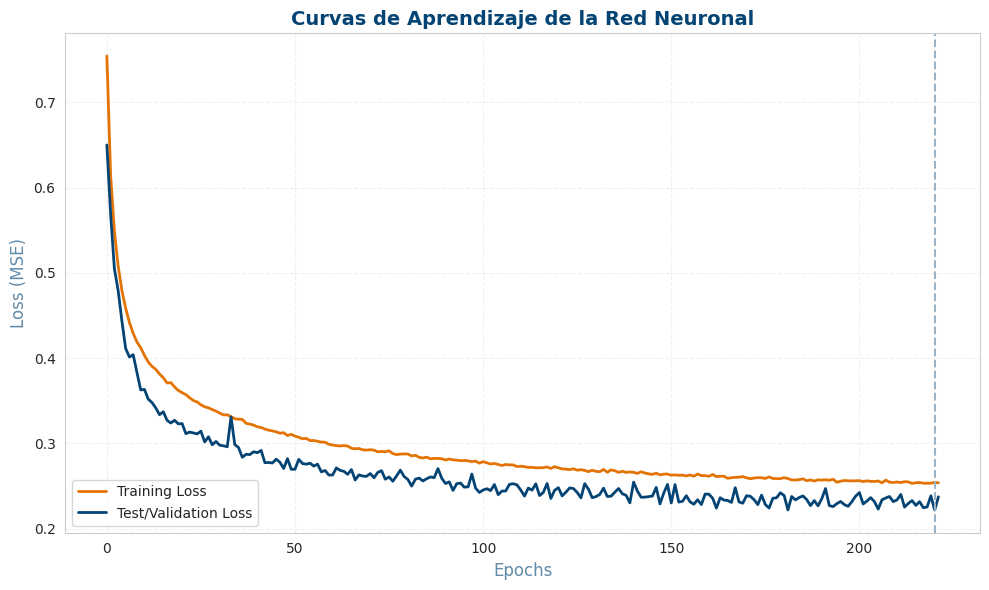

In [536]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color=naturgy_orange_palette[0], linewidth=2)
plt.plot(test_losses, label='Test/Validation Loss', color=naturgy_blue_palette[0], linewidth=2)
plt.title('Curvas de Aprendizaje de la Red Neuronal', fontsize=14, color=naturgy_blue_palette[0], fontweight='bold')
plt.xlabel('Epochs', fontsize=12, color=naturgy_blue_palette[1])
plt.ylabel('Loss (MSE)', fontsize=12, color=naturgy_blue_palette[1])
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=10)

best_epoch = test_losses.index(min(test_losses))
plt.axvline(x=best_epoch, color=naturgy_blue_palette[2], linestyle='--', 
            label=f'Mejor modelo (época {best_epoch+1})')

plt.tight_layout()
plt.show()

La gráfica se ve bastante bien, tanto training como test bajan de forma rápida indicando que el modelo está generalizado bien.

Probé con otro tipo de redes neuronales más específicos para series temporales, pero o por falta de lags, rollings etc o porque no preparo bien los datos los resultados no mejoran, eso sí TSLM da gráficas de loss vs epoch bastante estables.



### Funciones útiles para cargar y visualizar modelos

In [526]:
def evaluate_model(y_true, y_pred, model_name):
    results = {
        target: {
            'R2': r2_score(y_true[target], y_pred[:, i]),
            'RMSE': np.sqrt(mean_squared_error(y_true[target], y_pred[:, i])),
            'MAE': mean_absolute_error(y_true[target], y_pred[:, i]),
            'sMAPE': np.mean(np.abs((y_true[target] - y_pred[:, i]) / (y_true[target] + 1e-9))) * 100
        }
        for i, target in enumerate(y_true.columns)
    }
    df_results = pd.DataFrame(results).T
    print(f"--- Resultados para {model_name} ---")
    display(df_results)
    return df_results

In [538]:
def predict_with_neural_network(nn_model, X_data, nn_X_preprocessor, nn_y_scaler):
    """
    Realiza predicciones usando un modelo de red neuronal PyTorch,
    incluyendo preprocesamiento de X y escalado inverso de y.
    """
    if nn_model is None or nn_X_preprocessor is None or nn_y_scaler is None:
        print("Error: El modelo NN o sus componentes no están disponibles para la predicción.")
        return None

    # 1. Preprocesar X_data con el preprocesador de la NN
    X_data_scaled = nn_X_preprocessor.transform(X_data)
    
    # 2. Realizar predicciones con el modelo NN
    nn_model.eval()
    with torch.no_grad():
        y_pred_scaled = nn_model(torch.tensor(X_data_scaled, dtype=torch.float32)).numpy()
        
    # 3. Revertir el escalado de las predicciones
    y_pred_original_scale = nn_y_scaler.inverse_transform(y_pred_scaled)
    
    return y_pred_original_scale

In [539]:
def generate_comparison_plots(y_true_df, y_pred_xgb_data, y_pred_nn_data, dataset_name):
    """
    Genera y muestra gráficos de comparación para valores reales vs. predichos.
    """
    y_pred_xgb_df = None
    if y_pred_xgb_data is not None:
        y_pred_xgb_df = pd.DataFrame(y_pred_xgb_data, columns=y_true_df.columns, index=y_true_df.index)

    y_pred_nn_df = None
    if y_pred_nn_data is not None:
        y_pred_nn_df = pd.DataFrame(y_pred_nn_data, columns=y_true_df.columns, index=y_true_df.index)

    num_targets = len(y_true_df.columns)
    fig_height = max(15, num_targets * 5)
    fig, axes = plt.subplots(num_targets, 1, figsize=(18, fig_height), sharex=True)
    
    if num_targets == 1:
        axes = [axes]

    for i, target_col in enumerate(y_true_df.columns):
        ax = axes[i]
        y_true_df[target_col].plot(ax=ax, label=f'Valor Real ({dataset_name})', color='black', alpha=0.7)
        if y_pred_xgb_df is not None:
            y_pred_xgb_df[target_col].plot(ax=ax, label=f'Pred. XGBoost ({dataset_name})', 
                                          color=naturgy_blue_palette[0], linestyle='--')
        if y_pred_nn_df is not None:
            y_pred_nn_df[target_col].plot(ax=ax, label=f'Pred. PyTorch ({dataset_name})', 
                                         color=naturgy_orange_palette[0], linestyle=':')
        
        ax.set_title(f'Comparación de Predicciones para {target_col} ({dataset_name})', 
                    fontsize=12, color=naturgy_blue_palette[0], fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_ylabel('Valor', fontsize=10, color=naturgy_blue_palette[1])
        
    plt.tight_layout()
    plt.show()

In [540]:
def load_xgb_pipeline_model(model_path):
    """Carga un pipeline de XGBoost guardado con joblib."""
    try:
        pipeline = joblib.load(model_path)
        print(f"Pipeline XGBoost cargado desde: {model_path}")
        return pipeline
    except FileNotFoundError:
        print(f"ERROR: No se encontró el archivo del pipeline XGBoost: {model_path}")
        return None

### Resultados (en Conjunto de Validación)

--- Resultados para XGBoost (Validación) ---


R2         RMSE          MAE      sMAPE
renewable_H_plus_6  0.796624  1867.445213  1362.814661  12.291641
load_H_plus_6       0.897553  1440.722241  1004.700937   3.495286
renewable_H_plus_1  0.969492   723.183029   434.534922   3.960992
load_H_plus_1       0.986647   519.790706   313.268580   1.093828
price_H_plus_1      0.960352     2.459631     1.810902   3.101360

--- Resultados para Red Neuronal (PyTorch) (Validación) ---


R2         RMSE          MAE      sMAPE
renewable_H_plus_6  0.798433  1859.120601  1357.319815  12.387131
load_H_plus_6       0.810376  1960.096825  1481.159004   5.060964
renewable_H_plus_1  0.956510   863.453177   590.560515   5.389653
load_H_plus_1       0.962651   869.304349   648.637170   2.283899
price_H_plus_1      0.939531     3.037564     2.335380   4.037698


--- Comparativa de Tiempos de Entrenamiento ---


Modelo  Tiempo de Entrenamiento (s)
0                 XGBoost                   177.591160
1  Red Neuronal (PyTorch)                   159.627548


--- Gráficos de Comparación en el Conjunto de Validación ---


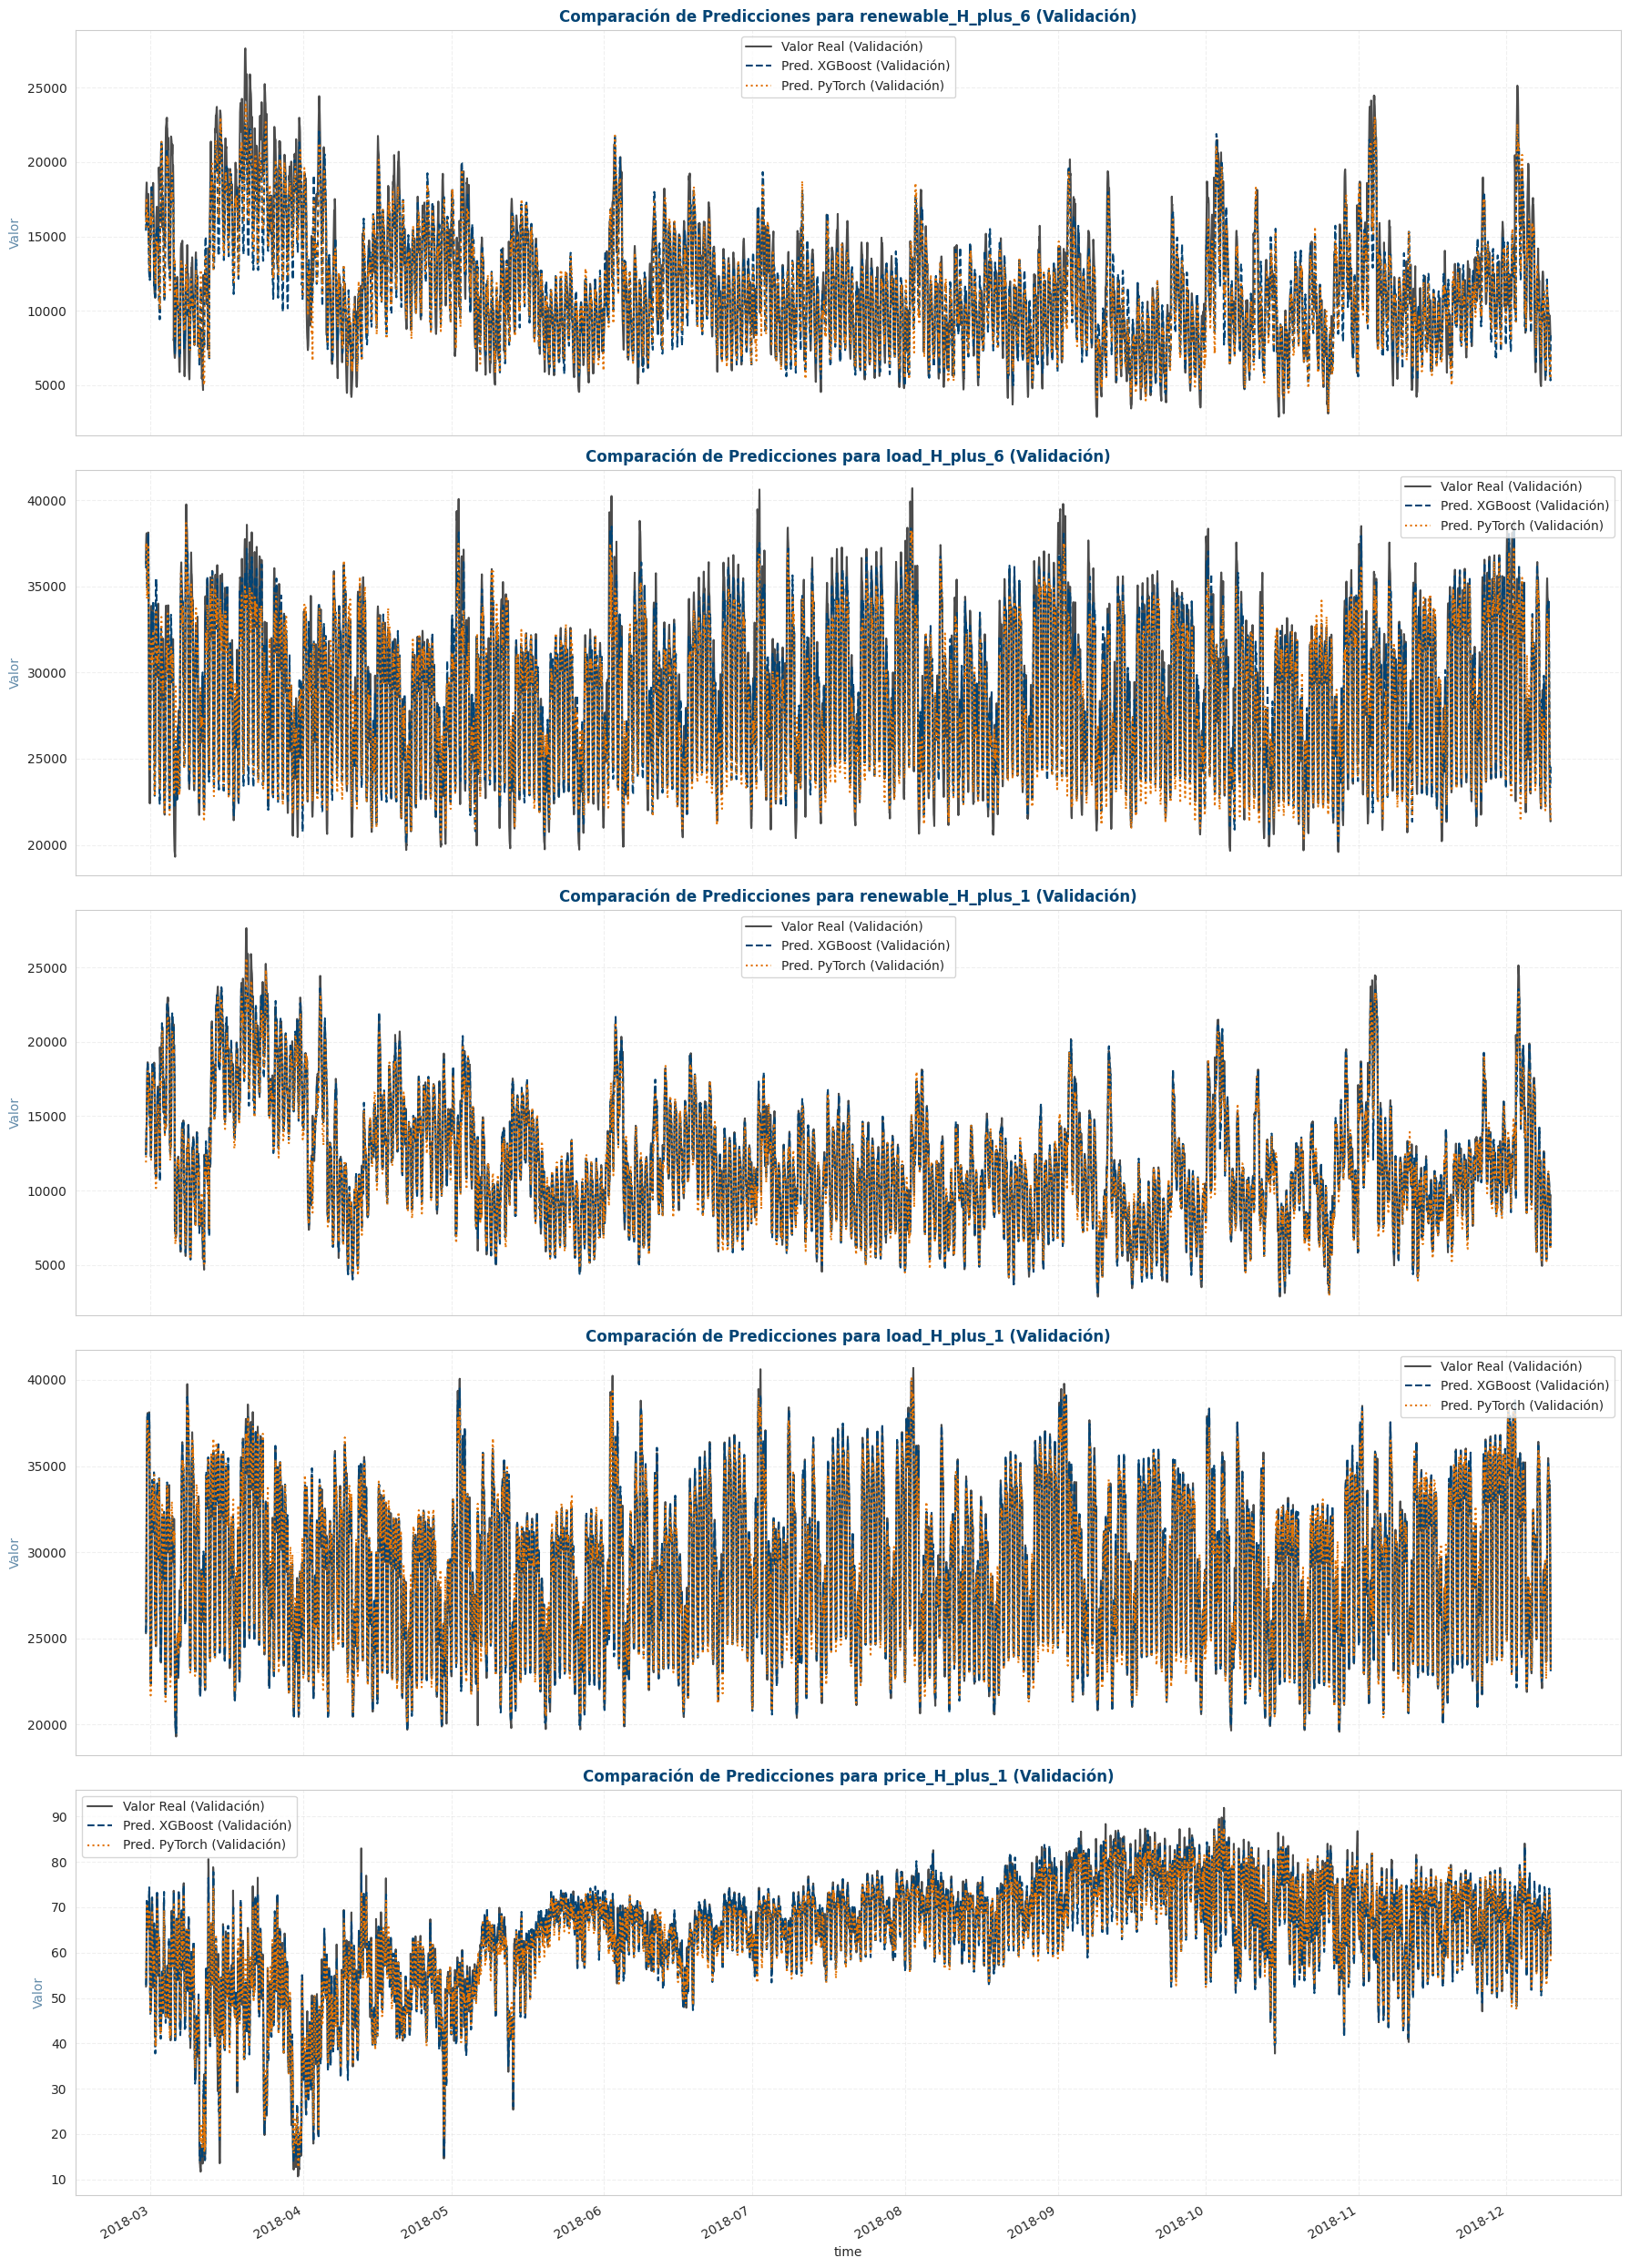

In [541]:
y_pred_xgb_val = xgb_pipeline.predict(X_val) 
y_pred_nn_val = predict_with_neural_network(model, X_val, preprocessor, y_scaler)

# --- Evaluación de Modelos en el CONJUNTO DE VALIDACIÓN ---
if y_pred_xgb_val is not None:
    results_xgb_val = evaluate_model(y_val, y_pred_xgb_val, 'XGBoost (Validación)')
if y_pred_nn_val is not None:
    results_nn_val = evaluate_model(y_val, y_pred_nn_val, 'Red Neuronal (PyTorch) (Validación)')

print("\n--- Comparativa de Tiempos de Entrenamiento ---")
training_times_data = {
    'Modelo': ['XGBoost', 'Red Neuronal (PyTorch)'],
    'Tiempo de Entrenamiento (s)': [training_time_xgb, training_time_nn]
}

df_training_times = pd.DataFrame(training_times_data)
display(df_training_times)

print("\n--- Gráficos de Comparación en el Conjunto de Validación ---")
generate_comparison_plots(y_val, y_pred_xgb_val, y_pred_nn_val, "Validación")

### Conclusiones de los modelos

- Los resultados para el Horizonte de predicciones de H+1 son más precisos que los calculados para H+6.
- Por lo general XGBoost tiene mejor rendimiento en casi todos los apartados R2 superior etc.
- La variable más difícil de calcular para ambos modelos es la Generación de Renovables + 6H posiblemente porque depende mucho de factores difíciles de calcular como puede ser la generación eólica y solar.
- El tiempo de entrenamiento es similar en ambos modelos.

En general el modelo más robusto con los datos de validación es XGBoost


## 8 Prueba Final

### Carga de Modelos y Preprocesadores

In [543]:
def load_neural_network_components(preprocessor_path, y_scaler_path, model_state_path, 
                                   ModelClass, input_size, output_size):
    """
    Carga un modelo de Red Neuronal PyTorch y sus componentes asociados.
    ModelClass es la clase del modelo (ej. MLP).
    input_size y output_size son las dimensiones necesarias para instanciar ModelClass.
    """
    
    loaded_preprocessor = joblib.load(preprocessor_path)
    print(f"Preprocesador de NN cargado desde: {preprocessor_path}")
    
    loaded_y_scaler = joblib.load(y_scaler_path)
    print(f"Escalador de targets de NN cargado desde: {y_scaler_path}")
    
    loaded_model = ModelClass(input_size, output_size)
    loaded_model.load_state_dict(torch.load(model_state_path))
    loaded_model.eval()
    print(f"Estado del modelo NN cargado desde: {model_state_path}")
        
    return loaded_model, loaded_preprocessor, loaded_y_scaler

In [544]:
print("\n--- Cargando Modelos y Preprocesadores Guardados ---")
model_filename_xgb = models_path + '/xgb_model-energy_weather.joblib'
loaded_xgb_pipeline = load_xgb_pipeline_model(model_filename_xgb)

preprocessor_filename_nn = models_path + '/nn_preprocessor.joblib'
y_scaler_filename_nn = models_path + '/nn_y_scaler.joblib'
model_state_filename_nn = models_path + '/nn_model_state.pth'


--- Cargando Modelos y Preprocesadores Guardados ---
Pipeline XGBoost cargado desde: ../Modelo_Entrenado//xgb_model-energy_weather.joblib


In [545]:
try:
    numeric_features_list = X_train.select_dtypes(include=np.number).columns.tolist() 
    actual_input_size_nn = len(numeric_features_list)
    actual_output_size_nn = y_train.shape[1]
    print(f"Determinadas dimensiones para MLP: input={actual_input_size_nn}, output={actual_output_size_nn}")
except NameError:
    print("ADVERTENCIA: X_train o y_train no están definidos. Debes establecer actual_input_size_nn y actual_output_size_nn manualmente.")
    actual_input_size_nn = 0 
    actual_output_size_nn = 0


loaded_nn_model, loaded_nn_preprocessor, loaded_nn_y_scaler = load_neural_network_components(
    preprocessor_filename_nn, 
    y_scaler_filename_nn, 
    model_state_filename_nn,
    MLP,
    actual_input_size_nn, 
    actual_output_size_nn 
)

Determinadas dimensiones para MLP: input=181, output=5
Preprocesador de NN cargado desde: ../Modelo_Entrenado//nn_preprocessor.joblib
Escalador de targets de NN cargado desde: ../Modelo_Entrenado//nn_y_scaler.joblib
Estado del modelo NN cargado desde: ../Modelo_Entrenado//nn_model_state.pth


### Predicciones y Evaluación en el Conjunto de Prueba Final


--- Realizando predicciones en el CONJUNTO DE PRUEBA FINAL ---
--- Resultados para XGBoost - Prueba Final ---


R2         RMSE          MAE      sMAPE
renewable_H_plus_6  0.823469  1484.932725  1186.277652  11.958129
load_H_plus_6       0.905611  1511.633135  1121.651317   4.124332
renewable_H_plus_1  0.974325   565.720860   402.244674   4.114768
load_H_plus_1       0.988410   533.791674   336.940117   1.280638
price_H_plus_1      0.933953     1.836295     1.400207   2.104182

--- Resultados para Red Neuronal - Prueba Final ---


R2         RMSE          MAE      sMAPE
renewable_H_plus_6  0.847161  1381.698408  1089.494666  11.027053
load_H_plus_6       0.846812  1925.743498  1428.098706   5.109202
renewable_H_plus_1  0.964282   667.256410   499.152064   5.006259
load_H_plus_1       0.974265   795.417798   610.786716   2.239124
price_H_plus_1      0.897759     2.284692     1.781431   2.662419


--- Gráficos de Comparación en el Conjunto de Prueba Final ---


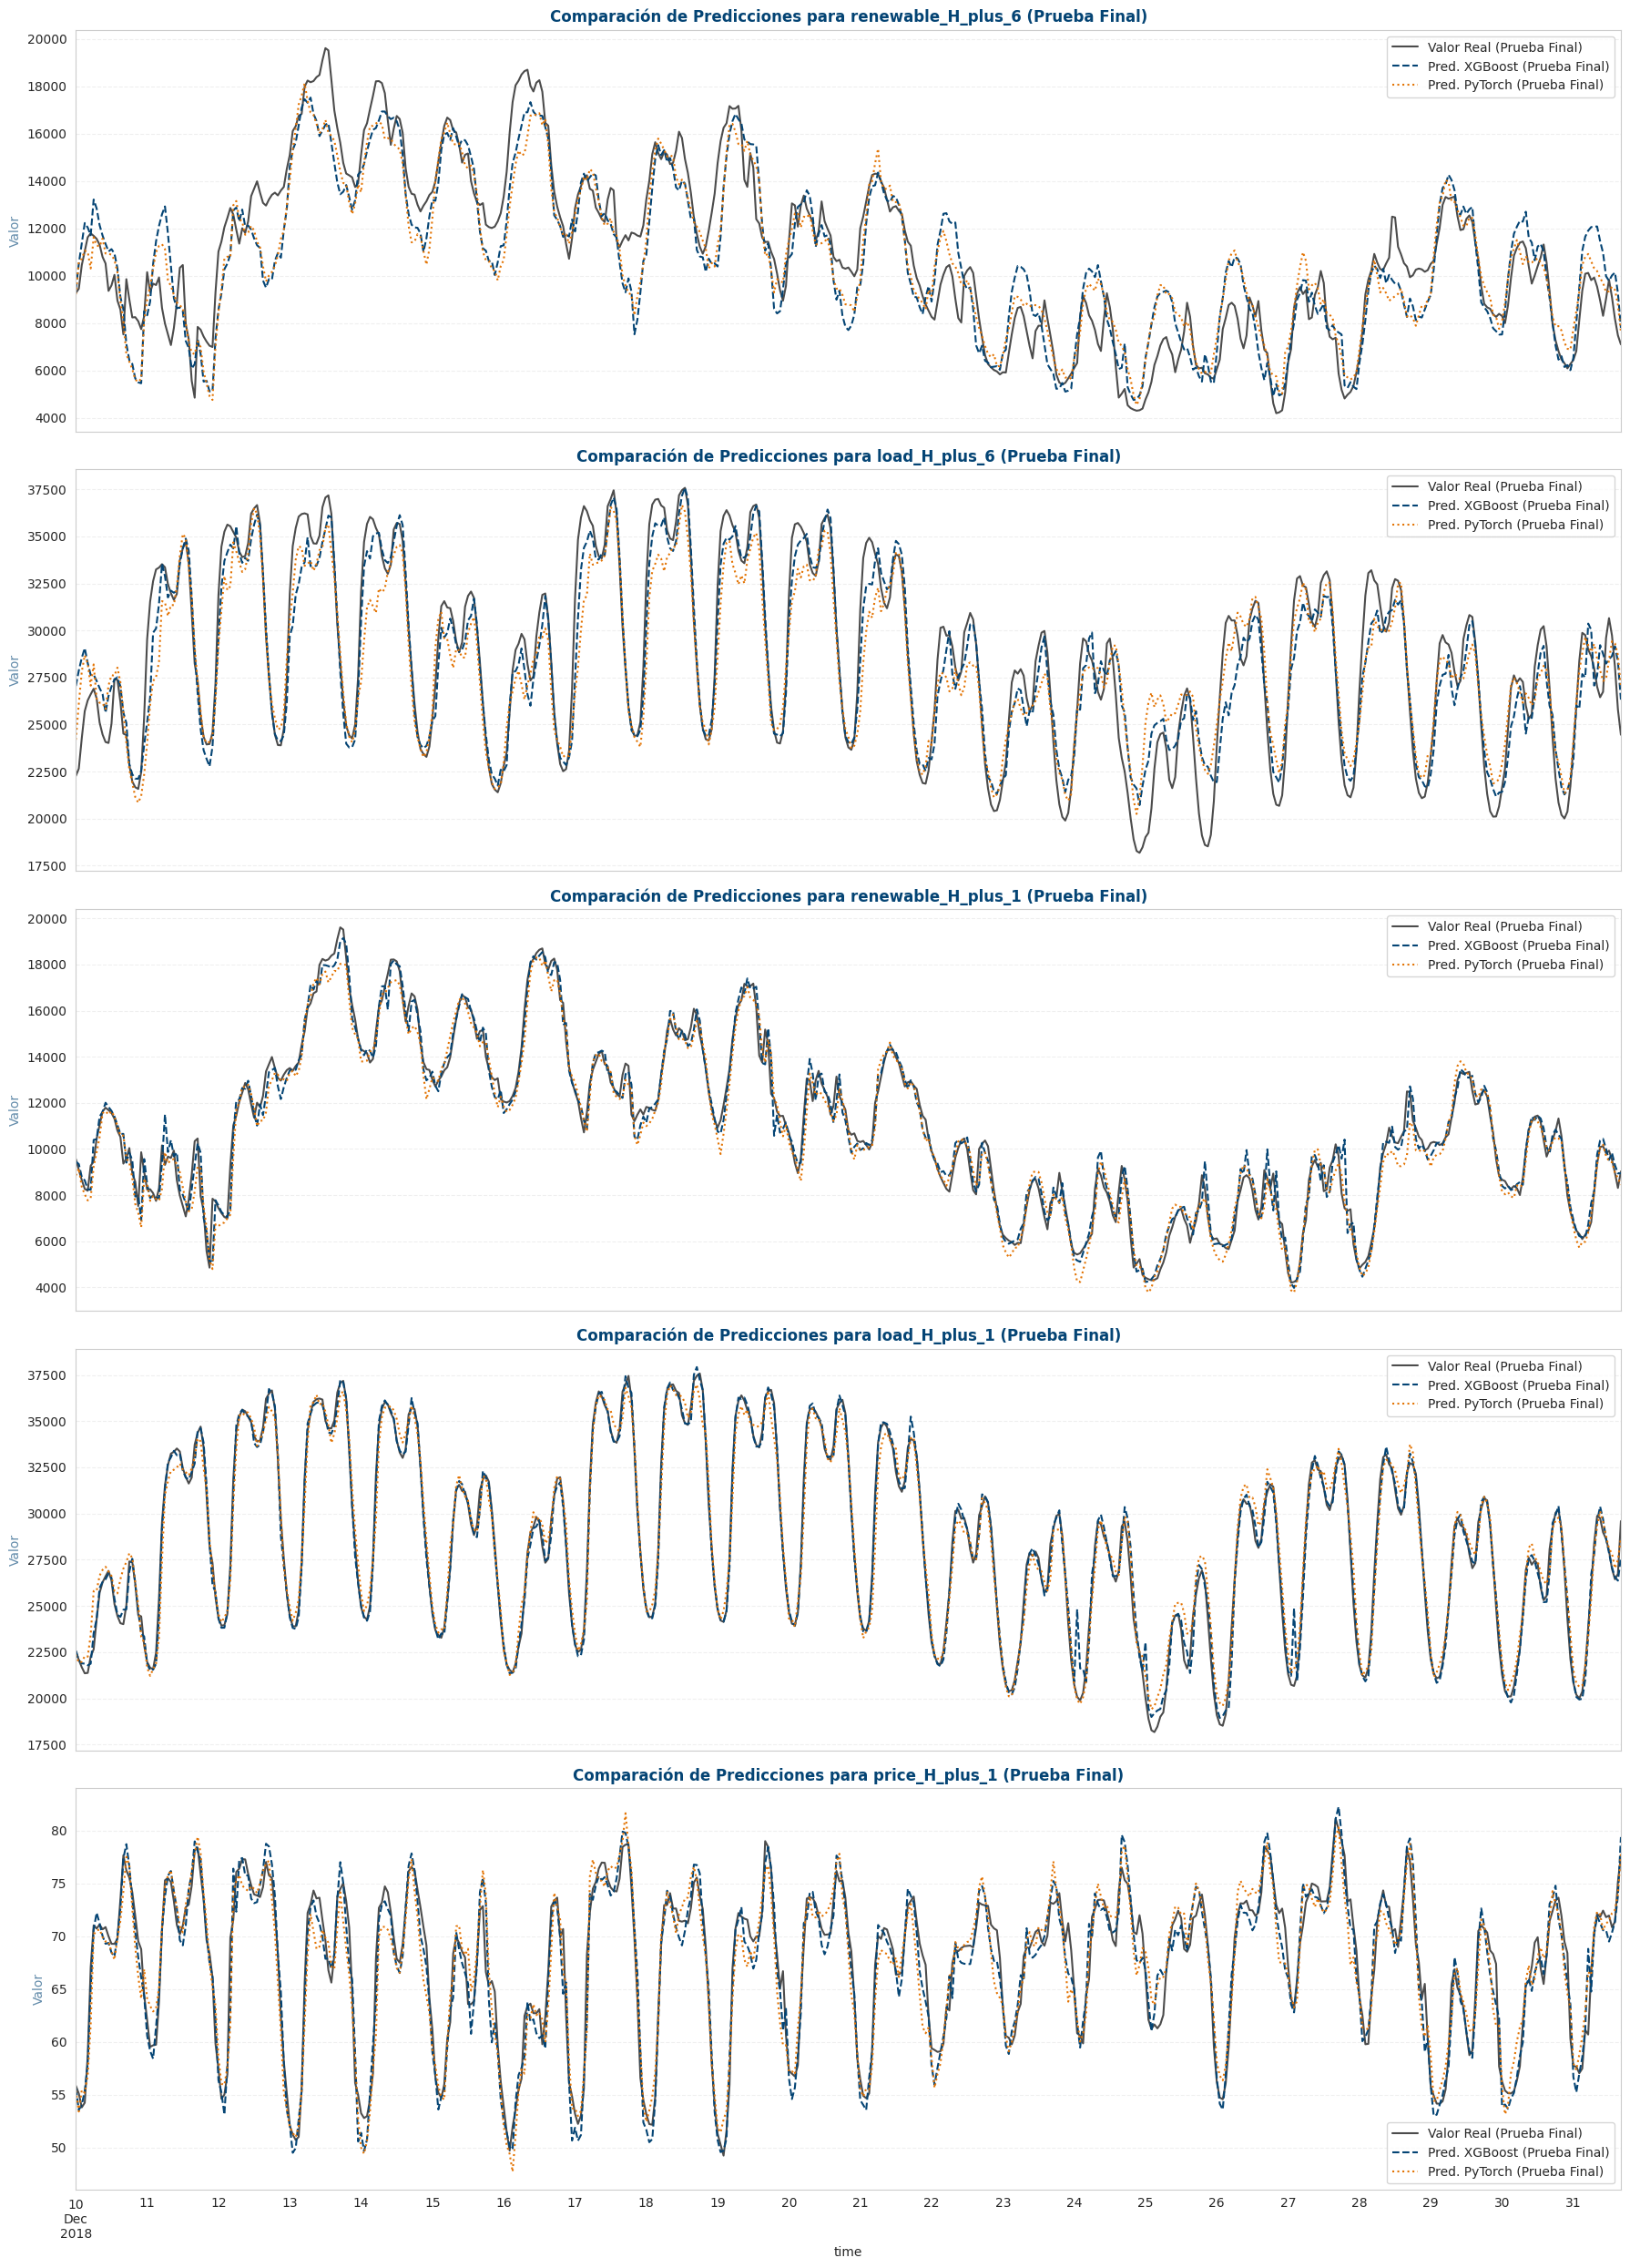


--- Prueba Final Completada ---


In [546]:
print("\n--- Realizando predicciones en el CONJUNTO DE PRUEBA FINAL ---")

y_pred_xgb_final = loaded_xgb_pipeline.predict(X_final_test)

y_pred_nn_final = predict_with_neural_network(
    loaded_nn_model, X_final_test, loaded_nn_preprocessor, loaded_nn_y_scaler
)
results_xgb_final = evaluate_model(y_final_test, y_pred_xgb_final, 'XGBoost - Prueba Final')
results_nn_final = evaluate_model(y_final_test, y_pred_nn_final, 'Red Neuronal - Prueba Final')

print("\n--- Gráficos de Comparación en el Conjunto de Prueba Final ---")
generate_comparison_plots(y_final_test, y_pred_xgb_final, y_pred_nn_final, "Prueba Final")

print("\n--- Prueba Final Completada ---")

### Conclusiones Finales del Rendimiento de los Modelos

- XGBoost definitivamente es el modelo más completo para nuestros objetivos. Probablemente su mejor rendimiento se debe a que a diferencia de la red neuronal no necesita una ingeniería tan refinada como la que podría necesitar una rede neuronal. A parte XGBoost es buena trantando datos tabulares estructurados.

- La red neuronal destaca por ser más preciso en las renovables + 6h probablemente a que encuentra patrones que XGBoost no puede ya que es la variable más dificl de calcular.

- Aunque el modelo tiene unos resultados que se podrían llevar a producción, a lo largo del tiempo estos modelos se podría refinar a medida que se van alimentando con más datos.